# TP Aprendizaje Automático 2
- Alsop Agustín (A-4651/7)
- Hachen Rocío (H-1184/3)

# Introducción

## Librerias

In [1]:
# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Imputación de datos faltantes
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# División y manejo de datasets
from sklearn.model_selection import train_test_split

# Modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Métricas y evaluación
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report
)
import shap

## Funciones

In [2]:
def simpleImputerPerMonth(x_train: pd.DataFrame, x_test: pd.DataFrame, imputer_method : str, columns : list) -> tuple:

    """
    Realiza la imputación de datos según la estrategia elegida, sobre las columnas seleccionadas, agrupando los datos por mes.

    Parámetros:
        x_train: Dataset de datos de entrenamiento
        x_test: Dataset de datos de prueba
        imputer_method: 
    
    Retorno: 
        Tupla que contiene los datos de entrenamientos imputados y los datos de prueba imputados.

    """

    methods = ['mean','median','most_frequent','constant']

    if imputer_method not in methods:
        raise ValueError(f'El imputer_method debe pertenecer a la lista de estrategias válidas: {methods}')
    
    for month in range(1, 13):
        
        imputer = SimpleImputer(strategy=imputer_method)
        
        # Filtramos el DataFrame por el mes y realizar la imputación
        train_filter = x_train['Date'].dt.month == month
        test_filter = x_test['Date'].dt.month == month
        
        x_train.loc[train_filter, columns] = imputer.fit_transform(x_train.loc[train_filter, columns])
        x_test.loc[test_filter, columns] = imputer.transform(x_test.loc[test_filter, columns])

    return(x_train, x_test)

In [3]:
def boxplots(X: pd.DataFrame,y : pd.DataFrame, columns : pd.Index ) -> None:

    """
    Gráfica boxplots según los datos otorgados

    Parámetros:
        X: Datos para visualizar en el eje X
        y: Datos para visualizar en el eje Y
        columns: Columnas a incluir

    """
    data = pd.concat([pd.DataFrame(y, columns=['RainTomorrow']), pd.DataFrame(X, columns=columns)], axis=1)

    num_features = X.shape[1]
    num_rows = num_features // 3 +1

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Se recorre cada feature para generar su diagrama de caja respecto de la salida
    for i, feature in enumerate(data.columns[1:]):
        row = i // 3
        col = i % 3
        sns.boxplot(x='RainTomorrow', y=feature, hue='RainTomorrow', data=data, ax=axes[row, col], palette=['blue', 'coral'], legend=False)
        axes[row, col].set_title(f'Diagrama de caja de {feature}')
        axes[row, col].set_xlabel('RainTomorrow')
        axes[row, col].set_ylabel(feature)
        axes[row, col].set_xticks([0, 1])
        axes[row, col].set_xticklabels(['No Lloverá', 'Lloverá'])

    # Eliminar subplots vacíos si es necesario
    if num_features % 3 != 0:
        for i in range(num_features % 3, 3):
            fig.delaxes(axes[num_rows - 1, i])

    plt.show()

In [4]:
def curvaRocCustom(test, prob) -> float:
    fpr, tpr, thresholds = roc_curve(test, prob)
    roc_auc = auc(fpr, tpr) 
    distancias = np.sqrt((fpr-0)**2 + (tpr-1)**2)

    idx_optimo = np.argmin(distancias)
    th_optimo = thresholds[idx_optimo]

    print(f'Umbral del punto más cercano a (0,1): {th_optimo}')

    punto_fpr = fpr[idx_optimo]
    punto_tpr = tpr[idx_optimo]

    print(f'Punto más cercano a (0,1): ({punto_fpr.round(2)}, {punto_tpr.round(2)})')

    # Grafico la curva ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.scatter(fpr[idx_optimo], tpr[idx_optimo], color='red', s=50, label=f'Punto Óptimo (Threshold = {th_optimo:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    return th_optimo

In [5]:
def logRegMetrics(y_test, y_pred, logreg_name : str):
    accuracy_logreg = accuracy_score(y_test, y_pred)
    confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
    classification_report_logreg = classification_report(y_test, y_pred)
    
    print(f"Métricas para {logreg_name}:")
    print(f'\nAccuracy: {accuracy_logreg}')
    print("\nMatriz de confusión:")
    print(confusion_matrix_logreg)
    print("\nReporte de clasificación:")
    print(classification_report_logreg)
    

## Carga de datos

In [6]:
data = pd.read_csv('weatherAUS.csv')

In [7]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Nuestro dataset (`weatherAUS`) contiene información climática de Australia de 2007 a 2017. En este trabajo, la variable que tendremos como objetivo predecir es 'RainTomorrow', que determina si al día siguiente del día del registro llovió o no.

In [8]:
ciudades = list(data['Location'].unique())
len(ciudades)

49

El dataset incluye registros de 49 ciudades de Australia, pero seleccionaremos 10 de manera aleatoria. Durante el desarrollo de este trabajo se trabajará con datos de estas 10 ciudades únicamente.

In [9]:
ciudades_elegidas = data['Location'].drop_duplicates()
ciudades_elegidas = ciudades_elegidas.sample(n=10, random_state=42)
print('Ciudades seleccionadas:')
ciudades_elegidas

Ciudades seleccionadas:


39538      Williamtown
136071    AliceSprings
142304       Katherine
133031      Launceston
52062      MountGinini
80998         Dartmoor
77989         Watsonia
74980         Portland
93280       Townsville
58142          Bendigo
Name: Location, dtype: object

In [10]:
# Filtramos los datos para solamente incluir aquellas ciudades seleccionadas
df = data[data['Location'].isin(ciudades_elegidas)]

# Corroboramos que el filtrado fue exitoso
print(df['Location'].unique())

#Tomaremos tal como da la posibilidad el trabajo práctico de analizar como si fuera una sola ubicación
df = df.drop('Location', axis=1)

['Williamtown' 'MountGinini' 'Bendigo' 'Portland' 'Watsonia' 'Dartmoor'
 'Townsville' 'Launceston' 'AliceSprings' 'Katherine']


In [11]:
print('Columnas del dataset:')
df.columns

Columnas del dataset:


Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [12]:
tipos_de_datos = df.dtypes

variables_cualitativas = tipos_de_datos[df.dtypes == 'object'].index
variables_cuantitativas = tipos_de_datos[df.dtypes != 'object'].index

print('Variables cualitativas:')
print(variables_cualitativas.tolist(),'\n')
print('Variables cuantitativas:')
print(variables_cuantitativas.tolist(),'\n')

Variables cualitativas:
['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 

Variables cuantitativas:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'] 



Como podemos observar, las variables son de tipo `float` o tipo `object`. Modificaremos algunas de ellas.

# Ejercicio 1

## Tratamiento de datos

### Codificación de Variables

A aquellas variables que son categóricas le asignaremos el tipo de dato ``category``. A la fecha (Date), le asignaremos el tipo de dato ``datetime64[ns]``

In [13]:
df_use = df.copy() # Para evitar warnings

#category_variable = ['RainToday','RainTomorrow','WindGustDir','WindDir9am','WindDir3pm']
category_variable = ['RainTomorrow','WindGustDir','WindDir9am','WindDir3pm']

for var in category_variable:
    df[var] = df_use[var].astype('category')

df['Date'] = df_use['Date'].astype('datetime64[ns]')

df[category_variable + ['Date']].dtypes

RainTomorrow          category
WindGustDir           category
WindDir9am            category
WindDir3pm            category
Date            datetime64[ns]
dtype: object

### Análisis y decisión sobre datos faltantes




Primero observaremos la cantidad total de nulls por variable.

In [14]:
# Nulls por Variable
nulls = df.isna().sum()
print(nulls)

print(f' Valores null totales: {nulls.sum()}')

Date                 0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64
 Valores null totales: 66912


### Tratamiento de los valores nulos
1) Las filas que tengan Nulls en la columna de la variable a predecir (``RainTomorrow``) se descartán

2) Luego de haber hecho la validación cruzada, se realizarán imputaciones dependiendo de su distribución y tipo de variable.
    - Asimetría -> Mediana
    - Normal -> Media
    - Bimodal y Categorica -> KNN

#### Paso 1

In [15]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['RainTomorrow'])
print(df['RainTomorrow'].isna().sum())

0


Como hemos eliminado los valores Null de la variable de salida, ahora la codificaremos a números enteros. De hacer esto antes, corremos el riesgo de que los Naan sean interpretados como una tercera categoría.

In [16]:
decision_map = {
    "No" : 0, "Yes" : 1
    }

# Aplicamos el mapeo para crear una nueva columna
df['RainTomorrow'] = df['RainTomorrow'].map(decision_map)

Nos aseguramos de tener solo 2 valores.

In [17]:
df['RainTomorrow'].unique()

[0, 1]
Categories (2, int64): [0, 1]

### División de datos

Para que no exista *data leakage*, realizaremos la división entre datos de entrenamiento y de prueba antes de realizar el análisis descriptivo.

In [18]:
# Division train - test
x = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

ratio_train = 0.8
ratio_test = 0.2

# Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test, random_state=42) # se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados

# y_train = y_train.to_numpy()
print(f'Cantidad de datos luego de la separación')
print(f'Train: {x_train.shape[0]} - 80%\n Test: {x_test.shape[0]} - 20%')

Cantidad de datos luego de la separación
Train: 22466 - 80%
 Test: 5617 - 20%


### Análisis descriptivo

Tenemos 23 variables en total.

1. *Date*: Fecha de la observación en formato YYYY-MM-DD.
2. *Location*: Nombre de la ubicación de la estación meteorológica.
3. *MinTemp*: Temperatura mínima registrada en grados Celsius en un día.
4. *MaxTemp*: Temperatura máxima registrada en grados Celsius en un día.
5. *Rainfall*: Cantidad de lluvia registrada en milímetros en un día.
6. *Evaporation*: Cantidad de evaporación de agua en milímetros en un día.
7. *Sunshine*: Horas de sol recibidas durante el día.
8. *WindGustDir*: Dirección de la ráfaga de viento más fuerte del día (puntos cardinales).
9. *WindGustSpeed*: Velocidad de la ráfaga de viento más fuerte en km/h.
10. *WindDir9am*: Dirección del viento a las 9 AM.
11. *WindDir3pm*: Dirección del viento a las 3 PM.
12. *WindSpeed9am*: Velocidad del viento a las 9 AM en km/h.
13. *WindSpeed3pm*: Velocidad del viento a las 3 PM en km/h.
14. *Humidity9am*: Humedad relativa medida a las 9 AM (en porcentaje).
15. *Humidity3pm*: Humedad relativa medida a las 3 PM (en porcentaje).
16. *Pressure9am*: Presión atmosférica medida a las 9 AM en hPa (hectopascales).
17. *Pressure3pm*: Presión atmosférica medida a las 3 PM en hPa.
18. *Cloud9am*: Cobertura de nubes a las 9 AM en octavos de cielo cubierto (0 a 8).
19. *Cloud3pm*: Cobertura de nubes a las 3 PM en octavos de cielo cubierto.
20. *Temp9am*: Temperatura medida a las 9 AM en grados Celsius.
21. *Temp3pm*: Temperatura medida a las 3 PM en grados Celsius.
22. *RainToday*: Indica si llovió más de 1 mm ese día ("Yes" o "No").
23. *RainTomorrow*: Variable objetivo que indica si se espera lluvia al día siguiente (1 mm o más) ("Yes" o "No").

In [19]:
variables_cualitativas = variables_cualitativas.drop('RainTomorrow')

In [20]:
print(x_train[variables_cualitativas.tolist()].describe(include='all'))

                                 Date WindGustDir WindDir9am WindDir3pm  \
count                           22466       22048      20765      22153   
unique                            NaN          16         16         16   
top                               NaN          NW         SE        ENE   
freq                              NaN        1691       1767       1782   
mean    2013-05-16 00:52:52.794445056         NaN        NaN        NaN   
min               2008-12-01 00:00:00         NaN        NaN        NaN   
25%               2011-03-02 00:00:00         NaN        NaN        NaN   
50%               2013-07-19 00:00:00         NaN        NaN        NaN   
75%               2015-07-15 00:00:00         NaN        NaN        NaN   
max               2017-06-25 00:00:00         NaN        NaN        NaN   

       RainToday  
count      22195  
unique         2  
top           No  
freq       17080  
mean         NaN  
min          NaN  
25%          NaN  
50%          NaN  
75%

In [21]:
x_train[variables_cuantitativas.tolist()].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,22358.000000,22432.000000,22195.000000,14826.000000,11635.000000,22050.000000,22294.000000,22307.000000,21900.000000,21440.000000,19215.000000,19214.000000,14128.000000,13482.000000,22085.000000,21683.000000
mean,11.136976,22.308791,2.370390,5.778302,7.400791,39.852880,13.282318,18.305285,70.873516,54.038153,1016.985803,1014.563188,4.518049,4.611556,16.065216,20.630715
std,7.130376,8.464360,8.432189,4.505051,3.904221,13.066766,8.167270,8.099486,21.599808,22.324861,7.222081,7.303454,2.942374,2.763651,7.719187,8.163236
min,-8.200000,-4.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,985.000000,980.200000,0.000000,0.000000,-7.200000,-5.400000
25%,6.100000,15.800000,0.000000,2.600000,4.300000,31.000000,7.000000,13.000000,59.000000,39.000000,1012.200000,1009.600000,1.000000,2.000000,10.600000,14.500000
50%,10.400000,21.500000,0.000000,5.200000,8.200000,39.000000,13.000000,19.000000,73.000000,55.000000,1017.000000,1014.500000,5.000000,5.000000,15.000000,19.800000
75%,15.800000,28.900000,0.800000,8.000000,10.600000,46.000000,19.000000,24.000000,89.000000,69.000000,1021.700000,1019.500000,7.000000,7.000000,21.700000,26.700000
max,30.300000,45.500000,236.800000,145.000000,14.300000,135.000000,65.000000,72.000000,100.000000,100.000000,1040.500000,1039.600000,8.000000,8.000000,39.100000,43.900000


#### Matriz de Correlación

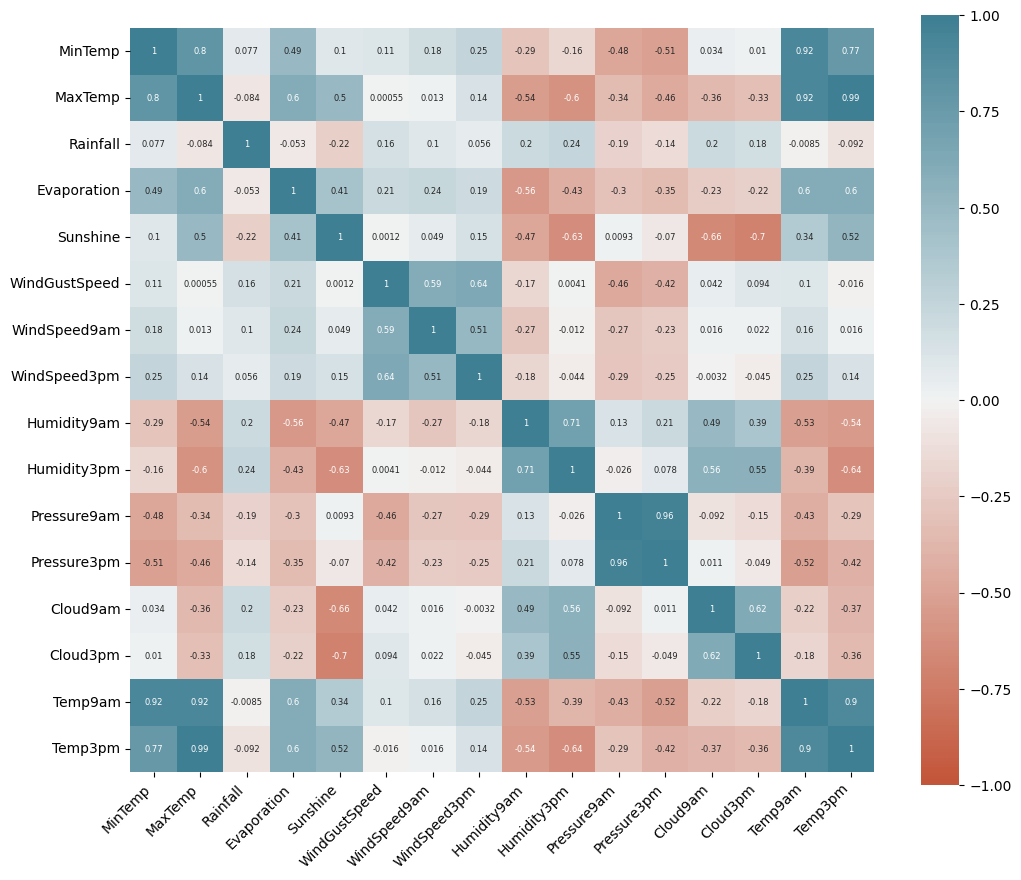

In [22]:
x_train_corr=pd.DataFrame(x_train,columns=x_train.drop(columns=['RainToday', 'Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm']).columns)

plt.figure(figsize=(12,10))
corr = x_train_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

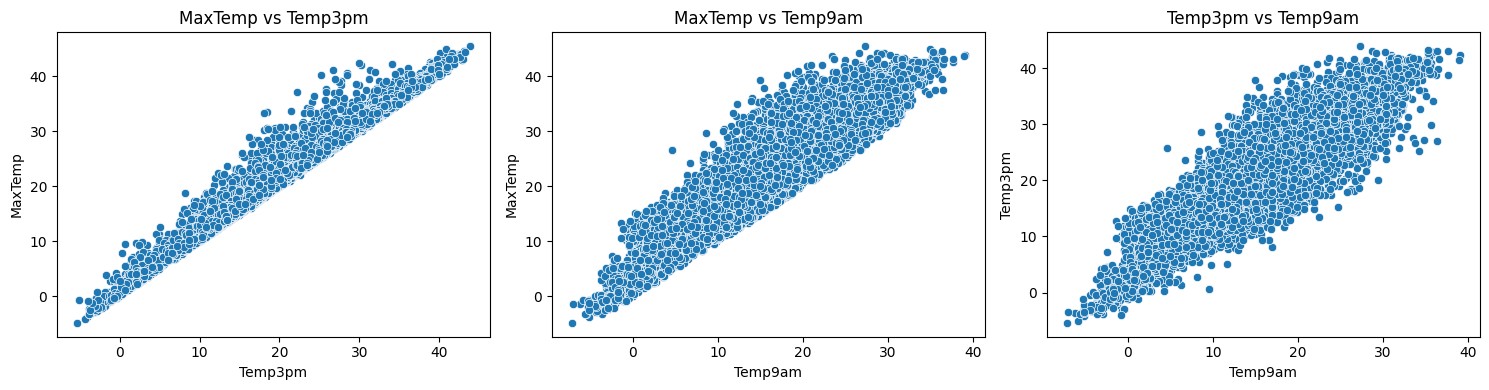

In [23]:
# Visualización de la relación entre algunas variables

pares = [('MaxTemp', 'Temp3pm'), ('MaxTemp', 'Temp9am'), ('Temp3pm', 'Temp9am')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

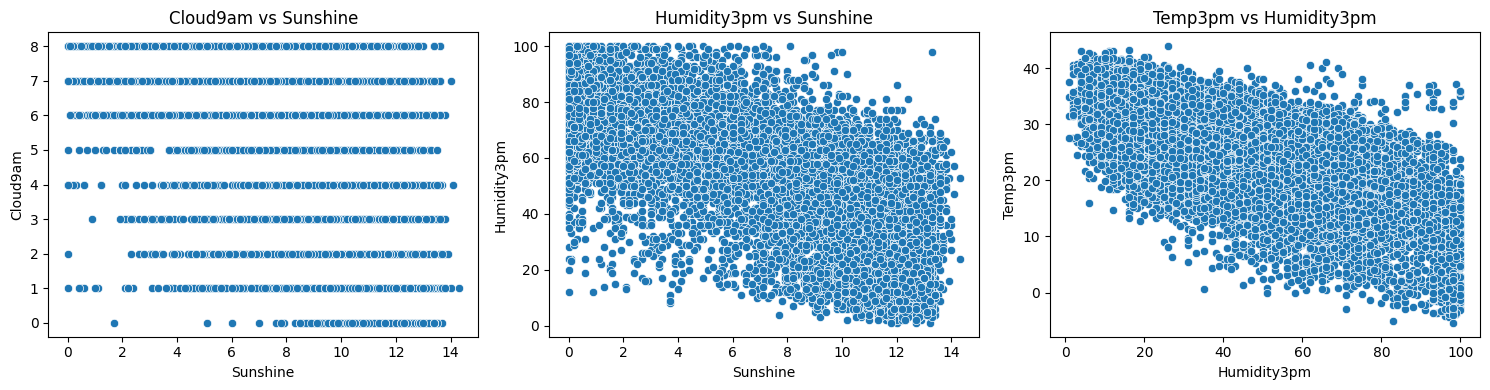

In [24]:
# Visualización de la relación negativa entre algunas variables

pares = [('Cloud9am', 'Sunshine'), ('Humidity3pm', 'Sunshine'), ('Temp3pm', 'Humidity3pm')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

- En la **matriz de correlacion** podemos destacar múltiples variables relacionadas. 
- Se destacan varias relaciones fuertemente **positivas**, es decir, mientras aumenta una variable, la otra se comporta de la misma manera. Un claro ejemplo es ``MaxTemp`` con ``Temp9am`` y ``Temp3pm``: esta relacion es intuitiva ya que la raiz del dato que se toma es la misma, la **temperatura**. Lo mismo sucede entre ``Temp9am`` y ``Temp3pm``. Podemos observar en los gráficos hechos anteriormente cómo mientras sube la temperatura a la mañana, también lo hace a la tarde.
- Por otro lado, podemos observar variables relacionadas **negativamente**, como ``Sunshine`` con ``Cloud3pm``. Se logra apreciar cómo a medida que los niveles de nubes bajan, la duración de la luz solar aumenta. Esta relacion tambien es intuitiva, ya que si no hay nubes, el sol no será tapado.

#### Analisis por variable individual

Para poder hacer un mejor análisis sobre los datos (presencia de outliers, distribución de los datos, etc.) decidimos graficar la distribución de cada variable. Además, incluímos la variable categórica "RainToday" en cada uno de los gráficos para poder apreciar mejor si los outliers realmente eran valores atípicos, o si se justificaban por su categoría.

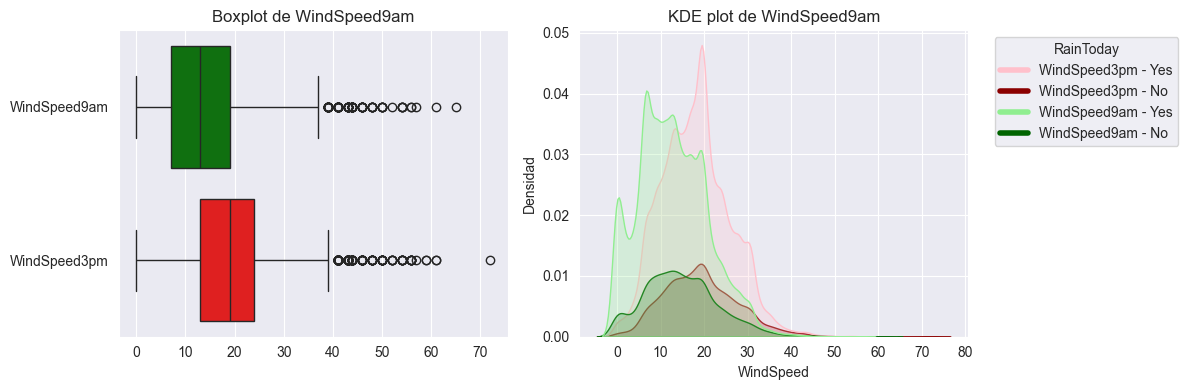

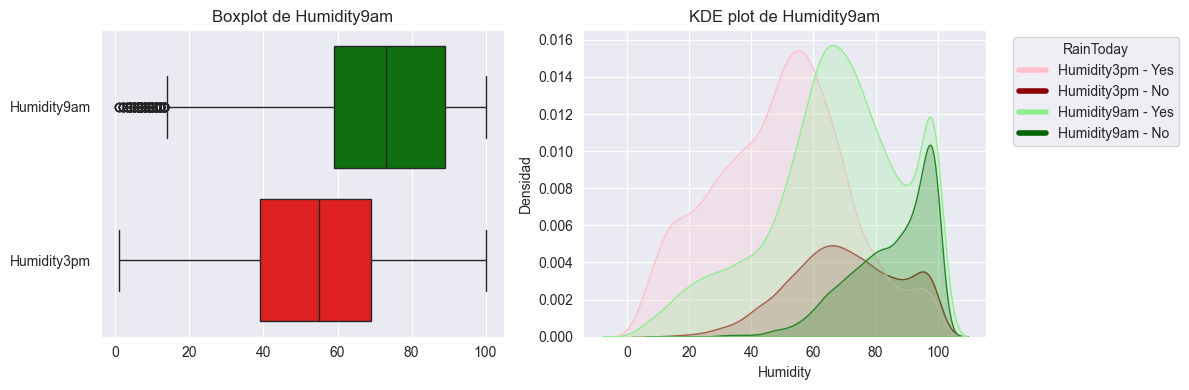

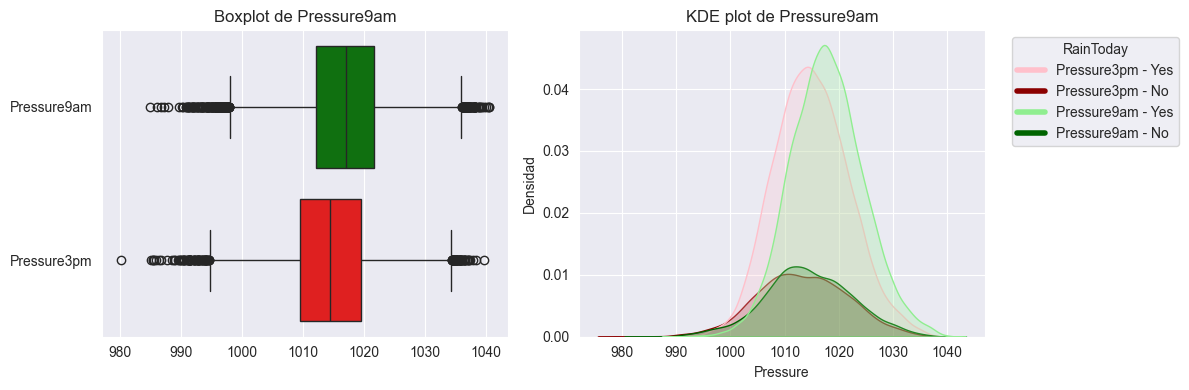

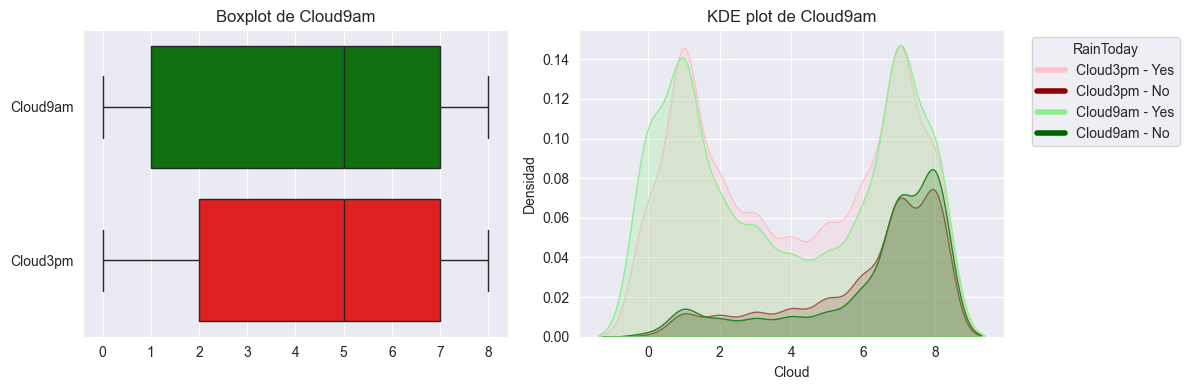

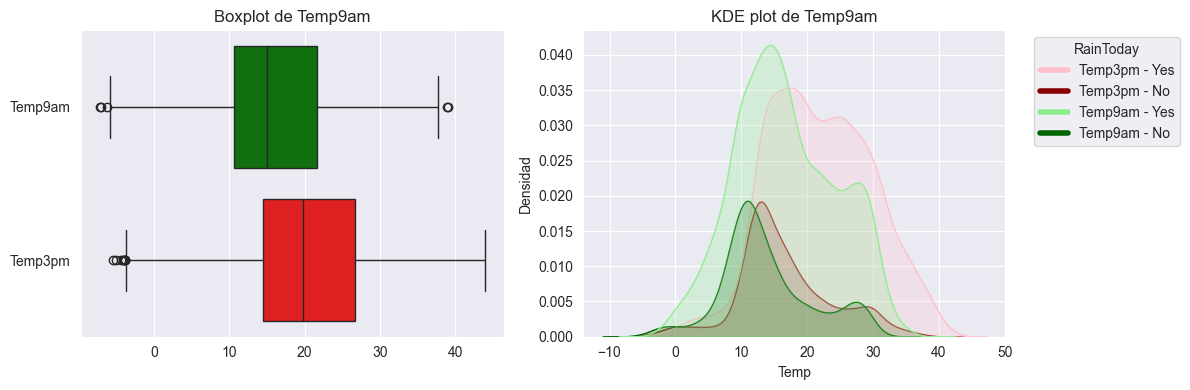

In [25]:


x_train_grafico=pd.DataFrame(x_train,columns=x_train.drop(columns=['Date']).columns)

am_pm_list = ["WindSpeed","Humidity","Pressure","Cloud","Temp"]

sns.set_style("darkgrid")
# Definir las paletas personalizadas
palette_a = ['lightgreen', 'darkgreen']  # Verde oscuro y verde claro
palette_b = ['pink', 'darkred'] 
palette_c = ['green', 'red']           # Rojo claro y rojo oscuro
for variable in am_pm_list:

    am = variable + '9am'
    pm = variable + '3pm'
    # Crear la figura
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(data=x_train[[am,pm]], ax=axs[0], 
                palette=palette_c,orient="h")
    axs[0].set_title(f'Boxplot de {am}')

    # Graficar el KDE para Temp3pm con rojo oscuro y rojo claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=pm, fill=True, hue='RainToday', 
                palette=palette_b, label=pm)
    axs[1].set_title(f'KDE plot de {pm}')
    axs[1].set_ylabel('Densidad')


    # Graficar el KDE para Temp9am con verde oscuro y verde claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=am, fill=True, hue='RainToday', 
                palette=palette_a, label=am)
    axs[1].set_title(f'KDE plot de {am}')
    axs[1].set_ylabel('Densidad')

    # Añadir la leyenda personalizada que relacione los colores con 'Yes' y 'No'
    # Cada hue tiene 'Yes' y 'No', por lo que mostramos dos entradas para cada variable
    legend_labels = [f'{pm} - Yes', f'{pm} - No', f'{am} - Yes', f'{am} - No']
    colors = palette_b + palette_a  # Los colores que usaste

    # Crear los elementos de la leyenda

    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]

    # Colocar la leyenda en la figura
    plt.legend(handles=legend_elements, title='RainToday', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(variable)
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    x_train_grafico = x_train_grafico.drop(columns=[am,pm])





MinTemp
count    22358.000000
mean        11.136976
std          7.130376
min         -8.200000
25%          6.100000
50%         10.400000
75%         15.800000
max         30.300000
Name: MinTemp, dtype: float64 



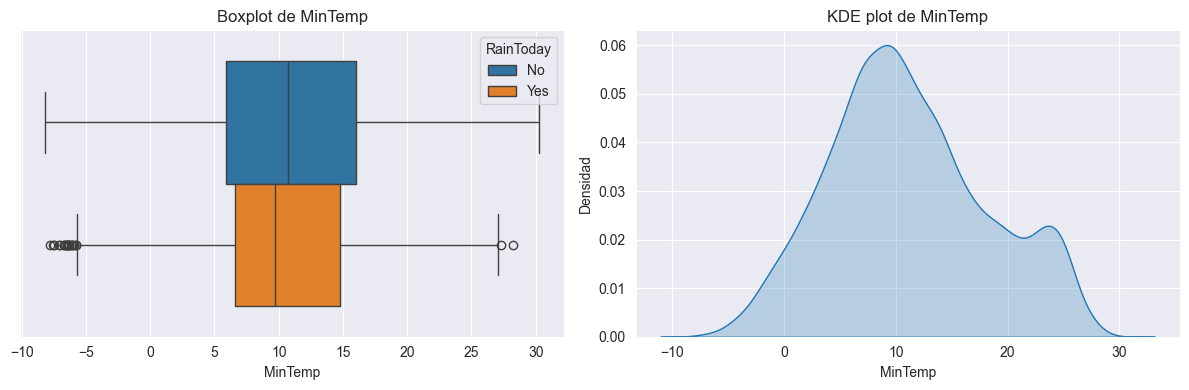

#############################################################################################
MaxTemp
count    22432.000000
mean        22.308791
std          8.464360
min         -4.800000
25%         15.800000
50%         21.500000
75%         28.900000
max         45.500000
Name: MaxTemp, dtype: float64 



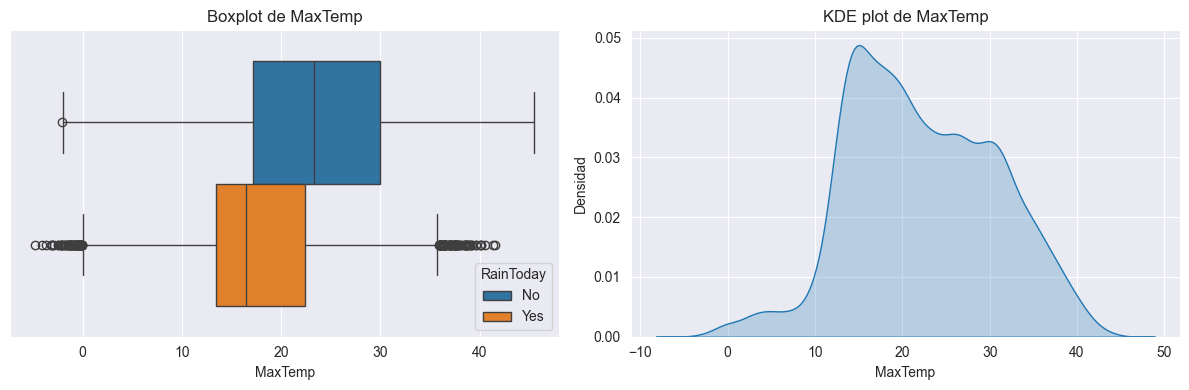

#############################################################################################
Rainfall
count    22195.000000
mean         2.370390
std          8.432189
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max        236.800000
Name: Rainfall, dtype: float64 



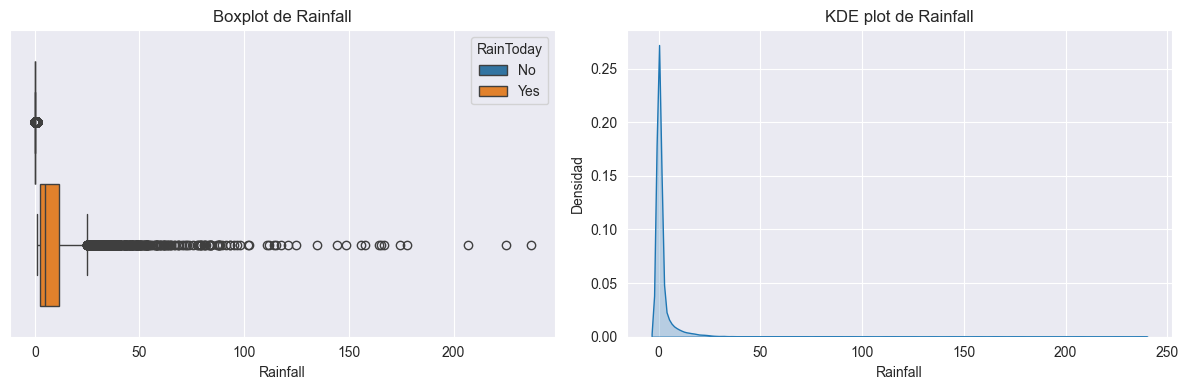

#############################################################################################
Evaporation
count    14826.000000
mean         5.778302
std          4.505051
min          0.000000
25%          2.600000
50%          5.200000
75%          8.000000
max        145.000000
Name: Evaporation, dtype: float64 



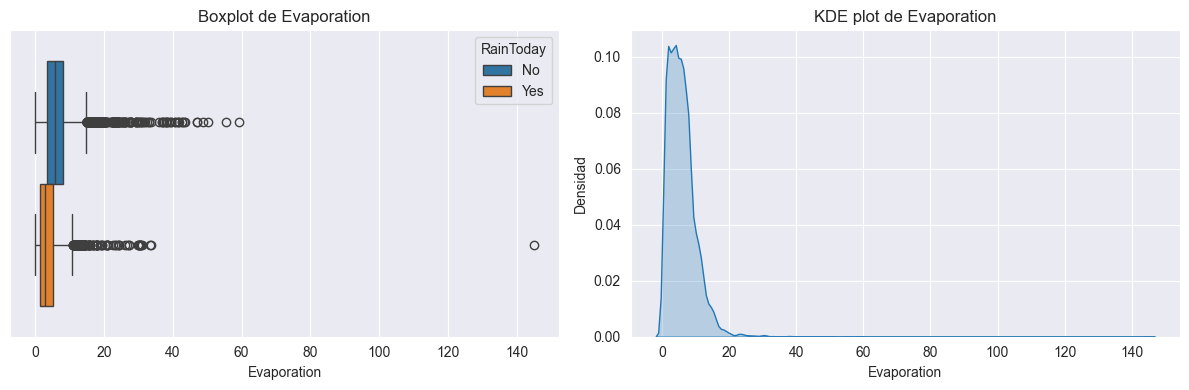

#############################################################################################
Sunshine
count    11635.000000
mean         7.400791
std          3.904221
min          0.000000
25%          4.300000
50%          8.200000
75%         10.600000
max         14.300000
Name: Sunshine, dtype: float64 



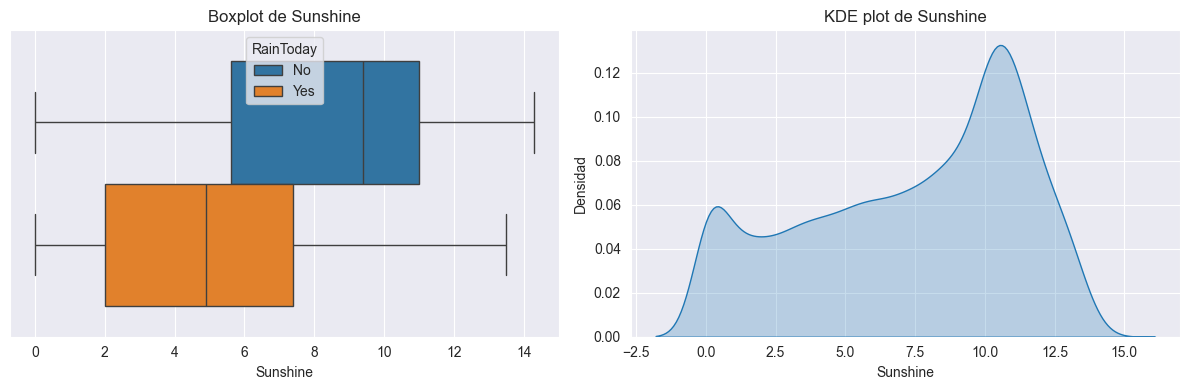

#############################################################################################
WindGustSpeed
count    22050.000000
mean        39.852880
std         13.066766
min          7.000000
25%         31.000000
50%         39.000000
75%         46.000000
max        135.000000
Name: WindGustSpeed, dtype: float64 



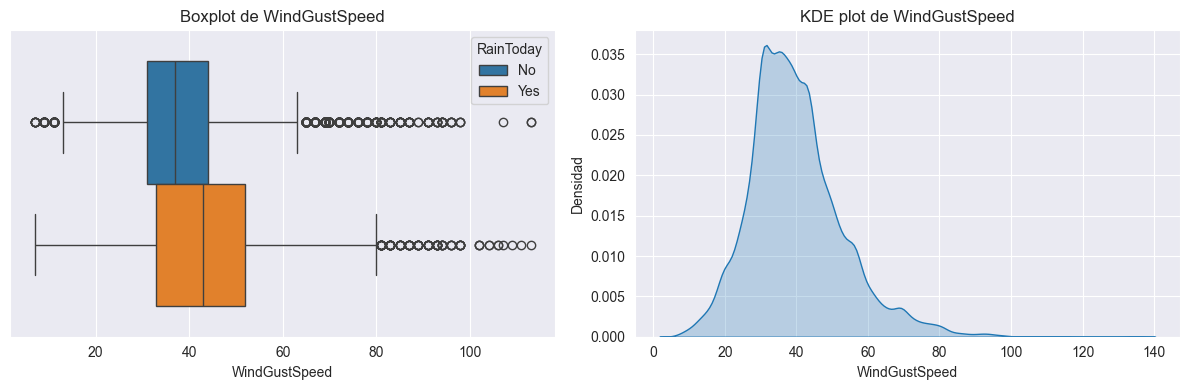

#############################################################################################
RainToday
count     22195
unique        2
top          No
freq      17080
Name: RainToday, dtype: object 



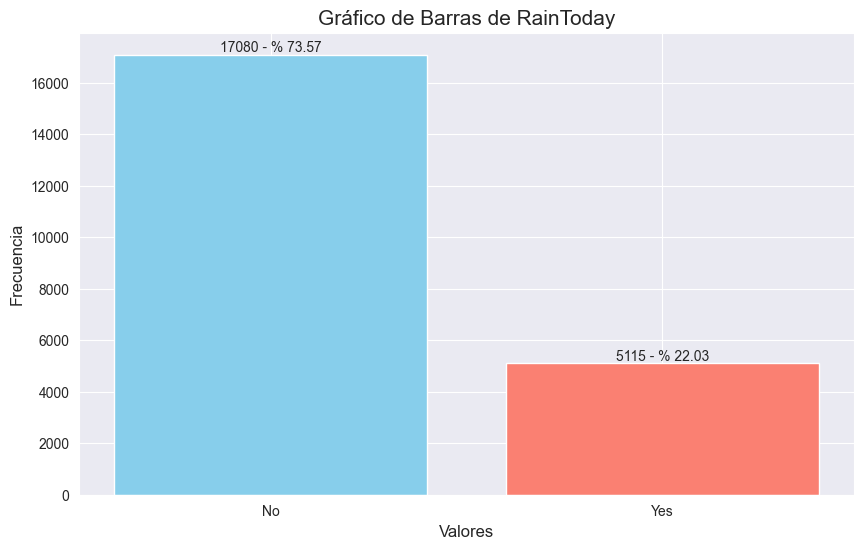

#############################################################################################
WindGustDir
count     22048
unique       16
top          NW
freq       1691
Name: WindGustDir, dtype: object 



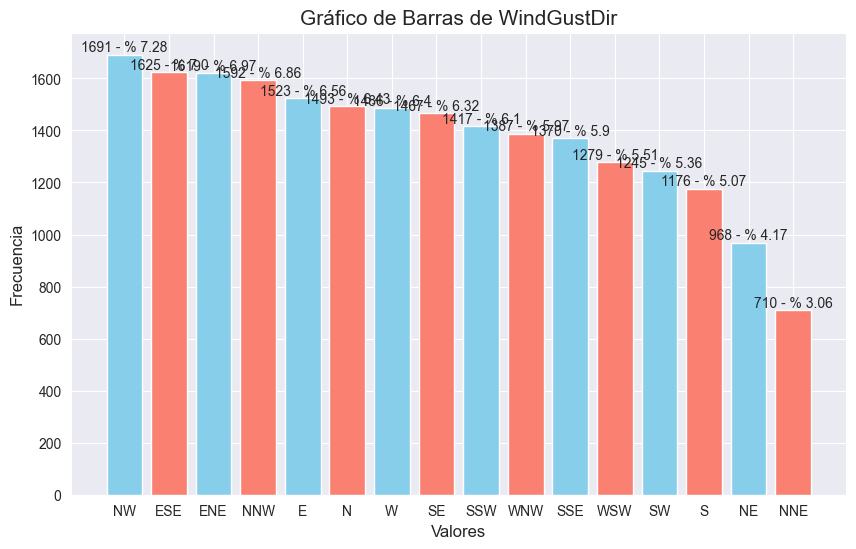

#############################################################################################
WindDir9am
count     20765
unique       16
top          SE
freq       1767
Name: WindDir9am, dtype: object 



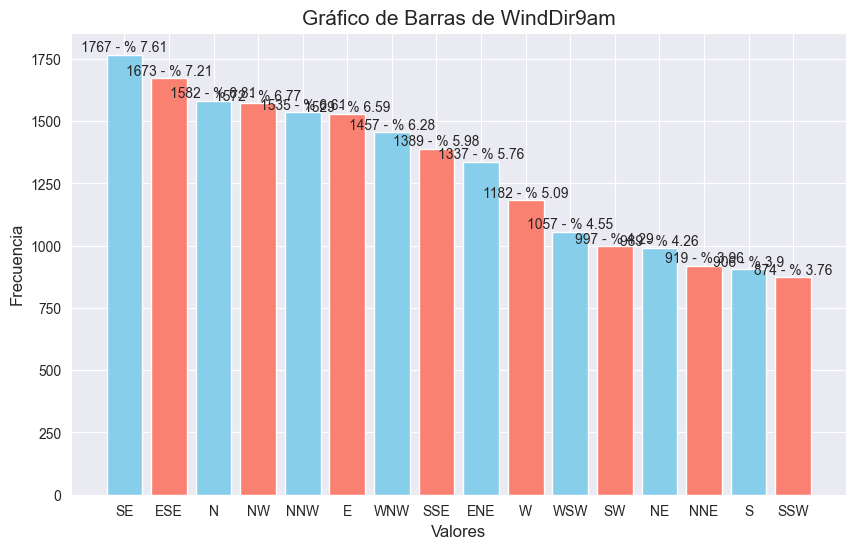

#############################################################################################
WindDir3pm
count     22153
unique       16
top         ENE
freq       1782
Name: WindDir3pm, dtype: object 



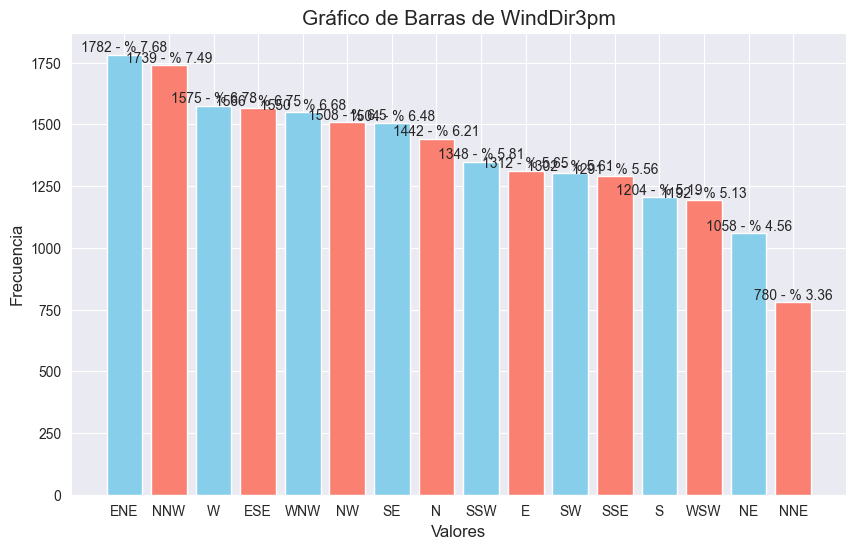

#############################################################################################


In [26]:
for columna in x_train_grafico:
    if not columna in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        print(columna)
        print(x_train[columna].describe(), '\n')

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=x_train, x=columna, hue=f'RainToday', ax=axs[0])
        axs[0].set_title(f'Boxplot de {columna}')

        sns.kdeplot(data=x_train, x=columna, fill=True, ax=axs[1])
        axs[1].set_title(f'KDE plot de {columna}')
        axs[1].set_ylabel('Densidad')

        plt.tight_layout()
        plt.show()

        print('#############################################################################################')

for i in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    print(i)
    print(x_train[f'{i}'].describe(), '\n')

    count = x_train[f'{i}'].value_counts().reset_index()
    count.columns = ['Valores', 'Frecuencia']

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(count['Valores'].astype(str), count['Frecuencia'], color=['skyblue', 'salmon'])

    # Agregar título y etiquetas
    plt.title(f'Gráfico de Barras de {i}', fontsize=15)
    plt.xlabel('Valores', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Agregar el número encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text((bar.get_x() + bar.get_width() / 2.0), height, f'{int(height)} - % {round((int(height)/23215)*100,2)}', ha='center', va='bottom')

    # Mostrar el gráfico
    plt.show()
    print('#############################################################################################')



En base a los gráficos, se observan las siguientes distribuciones:
- WindSpeed: Distribución asimétrica a la derecha esto se justifica viendo una gran cantidad de outliers en la parte derecha del boxplot. Estos outliers se presentan para ambos horarios, ademas podemos observar que la mediana de las velocidades de vientos a la 9am es ligeramente inferior que a las 3pm. Por otro lado la influencia si llueve en el dia o no podriamos decir que no afecta a las velocidades.
- Humidity: Distribución aproximadamente normal en el horario de las 3 de la tarde mientras que a la 9 de la mañana se observa una asimetria hacia la izquierda ibteniendo en promedio mayor humedad a la mañana que a la tarde. Se puede observar como la humedad se ve afectada positivamente los dias de lluvia obteniendo puntajes mayores.
- Preassure: Distribucion aproximadamente normal con una leve asimetria hacia la izquierda debido a que se pueden observar para ambos horarios mayor cantidad de outliers a la izquierda del boxplot. Tambien podemos observar que los dias que llueve la media de la presion atmosférica es levemente menor
- Cloud: Distribución Bimodal similares para ambos horarios. Podemos observar una moda alrededor de 1 y otra alrededor de los 7 puntos. Los dias de lluvia vemos como deja de ser una distribucion bimodal, a una con una aproximadamente normal asimetrica hacia la izquierda.
- Temp: Distribución aproximadamente normal con outliers en sus dos colas con mayor frecuencioa en el lado izquierdo. Los mismos se presentan para ambos horarios. Se oberva que los dias de lluvia la termperatura en inferior.
- MinTemp: Distribución bimodal. 
- MaxTemp: Distribución apróximadamente normal. El boxplot presenta algunos outlier, los dias de lluvia la mediana de las maximas temperaturas es inferior.
- Rainfall: Distribución muy asimetrica hacia la derecha, podemos observar gran cantidad de outliers en la parte derecha del boxplot, lo que explica esta gran asimetría
- Evaporation: Al igual que Rainfall podemos observar una distribución asimétrica hacia la derecha. Tambien se observan gran cantidad de outliers tanto para los dias de lluvia como para los que no.
- Sunshine: Distribución bimodal, una muy marcada al rededor de los 10 puntos y otra mas leve al rededor de los 0 puntos. Si bien es intuitivo se observa que los dias de lluvia la mediana de los puntos de sunshine son inferiores.
- WindGustSpeed: Distribución aproximadamente normal asimétrica a la derecha. Se pueden observar outliers en la parte derecha de los boxplot. Ademas los dias de lluvia presentan una mediana mayor de WindGustSpeed
- RainToday: Podemos observar un desbalanceo en los datos dando un 76% de los datos provienen de dias que no llueven mientras que un 21% que no.
- WindGustDir: Podemos observer que los datos se distribuyen entre un 4% a 8% entre cada categoria, siendo mas frecuentes WINDGUSTDIR del sur oeste y los menos fruentes del NorNorEste
- WindDir9am: Podemos observer que los datos se distribuyen entre un 3% a 10% entre cada categoria, siendo mas frecuentes los vientos en dirección al sursuereste y los menos fruentes del oestenoroeste
- WindDir3pm: Podemos observer que los datos se distribuyen entre un 4% a 8% entre cada categoria, siendo mas frecuentes los vientos en dirección al sur oeste y los menos fruentes del estenoreste

#### Paso 2 (Imputación de datos)

En base al análisis descriptivo, decidimos utilizar distintos métodos de imputación según la distribución y el tipo de variable.

### Continuas
- MinTemp: KNN
- Temp9am: Media
- Rainfall: Mediana
- Evaporation: Mediana
- WindGustSpeed: Mediana
- Pressure3pm: Mediana
- Pressure9am: Mediana
- WindSpeed3pm: KNN
- WindSpeed9am: KNN
- Humidity3pm: KNN
- Humidity9am: KNN
- Cloud9am: KNN
- Cloud3pm: KNN
- Temp3pm: KNN
- MaxTemp: Mediana?
- Sunshine: KNN

### Cualitativas
- WindGustDir: KNN
- WindDir9am: KNN
- WindDir3pm: KNN
- RainToday: KNN

In [27]:
# Creamos copias de los dataset
x_train_imputer = x_train.copy()
x_test_imputer = x_test.copy()

# Imputamos por la media
columns_normal = ['MaxTemp', 'Temp9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'mean', columns_normal)

# Imputamos por la mediana
columns_asimetric = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'Pressure3pm', 'Pressure9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'median', columns_asimetric)

# Imputamos por KNN
columns_bimodal = ['WindSpeed3pm', 'WindSpeed9am', 'Humidity3pm', 'Humidity9am', 'Cloud9am','Cloud3pm', 'Temp3pm', 'MinTemp','Sunshine']
knn_imputer = KNNImputer()
x_train_imputer[columns_bimodal]= knn_imputer.fit_transform(x_train_imputer[columns_bimodal])
x_test_imputer[columns_bimodal]= knn_imputer.transform(x_test_imputer[columns_bimodal])

# Verificamos
x_train_imputer.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir       418
WindGustSpeed       0
WindDir9am       1701
WindDir3pm        313
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday         271
dtype: int64

Codificación de direcciones de viento

In [28]:
x_train_mapping = x_train_imputer.copy()
x_test_mapping = x_test_imputer.copy()

# Mapeamos las direcciones del viento a ángulos
angle_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Se mapea cada dirección a su ángulo
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    x_train_mapping[f'{col}_angulo'] = x_train_mapping[col].map(angle_map).astype(float) # Se debe transformar a float, ya que si no serán categoricas
    x_test_mapping[f'{col}_angulo'] = x_test_mapping[col].map(angle_map).astype(float)

# Convertimos los ángulos a valores seno y coseno
for col in ['WindGustDir_angulo', 'WindDir9am_angulo', 'WindDir3pm_angulo']:
    x_train_mapping[f'{col}_sin'] = np.sin(np.radians(x_train_mapping[col])) # Se pasan a radianes ya que np.sin y np.cos esperan ángulos en radianes
    x_train_mapping[f'{col}_cos'] = np.cos(np.radians(x_train_mapping[col]))
    x_test_mapping[f'{col}_sin'] = np.sin(np.radians(x_test_mapping[col]))
    x_test_mapping[f'{col}_cos'] = np.cos(np.radians(x_test_mapping[col]))

# Descartamos las columnas originales y las _angulo
x_train_mapping = x_train_mapping.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm',
                              'WindGustDir_angulo', 'WindDir9am_angulo', 'WindDir3pm_angulo'])
x_test_mapping = x_test_mapping.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm',
                             'WindGustDir_angulo', 'WindDir9am_angulo', 'WindDir3pm_angulo'])

# Visualizamos una de las nuevas columnas
x_train_mapping[['WindDir3pm_angulo_cos','WindDir3pm_angulo_sin']]

,WindDir3pm_angulo_cos,WindDir3pm_angulo_sin
78688,-3.826834e-01,9.238795e-01
52091,-1.836970e-16,-1.000000e+00
82322,-3.826834e-01,-9.238795e-01
81408,-7.071068e-01,7.071068e-01
82198,-7.071068e-01,-7.071068e-01
...,...,...
134141,7.071068e-01,-7.071068e-01
55032,3.826834e-01,-9.238795e-01
40445,-9.238795e-01,-3.826834e-01
82367,NaN,NaN


Codificación de la fecha

In [29]:
# Para poder mantener parte de la data de Date, aislamos el mes y luego lo codificamos.

# Mes
x_train_mapping['Month'] = x_train_mapping['Date'].dt.month
x_test_mapping['Month'] = x_test_mapping['Date'].dt.month


In [30]:
# Codificación seno-coseno para Mes (1-12)

x_train_mapping['Month_sin'] = np.sin(2 * np.pi * x_train_mapping['Month'] / 12)
x_train_mapping['Month_cos'] = np.cos(2 * np.pi * x_train_mapping['Month'] / 12)
x_test_mapping['Month_sin'] = np.sin(2 * np.pi * x_test_mapping['Month'] / 12)
x_test_mapping['Month_cos'] = np.cos(2 * np.pi * x_test_mapping['Month'] / 12)

x_train_mapping = x_train_mapping.drop(columns=['Month'])
x_test_mapping = x_test_mapping.drop(columns=['Month'])

Utilizamos la codificación de LabelEncoder para la variable RainToday

In [31]:
from sklearn.preprocessing import LabelEncoder

# Hacemos una copia para trabajar en ella
x_train_imputer_v2 = x_train_mapping.copy()
x_test_imputer_v2 = x_test_mapping.copy()

for var in ['RainToday']:
    label_encoder = LabelEncoder()
    
    non_null_train = x_train_imputer_v2[var].notnull()
    non_null_test = x_test_imputer_v2[var].notnull()
    
    # Ajusta el codificador en los datos no nulos
    x_train_imputer_v2.loc[non_null_train, var] = label_encoder.fit_transform(x_train_imputer_v2.loc[non_null_train, var])
    x_test_imputer_v2.loc[non_null_test, var] = label_encoder.transform(x_test_imputer_v2.loc[non_null_test, var])


In [32]:
x_train_imputer_v2['RainToday'].value_counts()


RainToday
0    17080
1     5115
Name: count, dtype: int64

In [33]:
x_train_imputer_v2['RainToday'].isna().sum()

271

In [34]:
# Eliminamos la columna date
x_train_imputer_v2 = x_train_imputer_v2.drop(columns=['Date']).reset_index(drop=True)
x_test_imputer_v2 = x_test_imputer_v2.drop(columns=['Date']).reset_index(drop=True)

# Imputamos las columnas codificadas
columns_bimodal_cat = ['WindGustDir_angulo_cos','WindGustDir_angulo_sin','WindDir9am_angulo_cos','WindDir9am_angulo_sin','WindDir3pm_angulo_cos','WindDir3pm_angulo_sin','RainToday']

knn_imputer = KNNImputer()

x_train_imputer_v2[columns_bimodal_cat]= knn_imputer.fit_transform(x_train_imputer_v2[columns_bimodal_cat])
x_test_imputer_v2[columns_bimodal_cat]= knn_imputer.transform(x_test_imputer_v2[columns_bimodal_cat])

x_train_imputer_v2['RainToday'] = x_train_imputer_v2['RainToday'].round()
x_test_imputer_v2['RainToday'] = x_test_imputer_v2['RainToday'].round()

# Verificamos que no queden Null
x_train_imputer_v2.isna().sum()

MinTemp                   0
MaxTemp                   0
Rainfall                  0
Evaporation               0
Sunshine                  0
WindGustSpeed             0
WindSpeed9am              0
WindSpeed3pm              0
Humidity9am               0
Humidity3pm               0
Pressure9am               0
Pressure3pm               0
Cloud9am                  0
Cloud3pm                  0
Temp9am                   0
Temp3pm                   0
RainToday                 0
WindGustDir_angulo_sin    0
WindGustDir_angulo_cos    0
WindDir9am_angulo_sin     0
WindDir9am_angulo_cos     0
WindDir3pm_angulo_sin     0
WindDir3pm_angulo_cos     0
Month_sin                 0
Month_cos                 0
dtype: int64

In [35]:
x_train_imputer_v2['RainToday'].value_counts()

RainToday
0.0    17289
1.0     5177
Name: count, dtype: int64

In [36]:
x_train_imputer.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

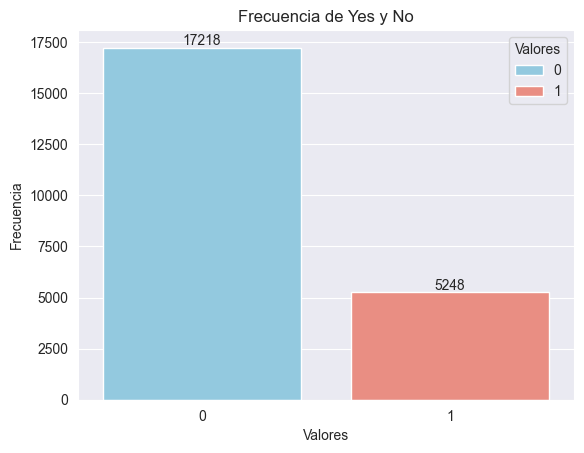

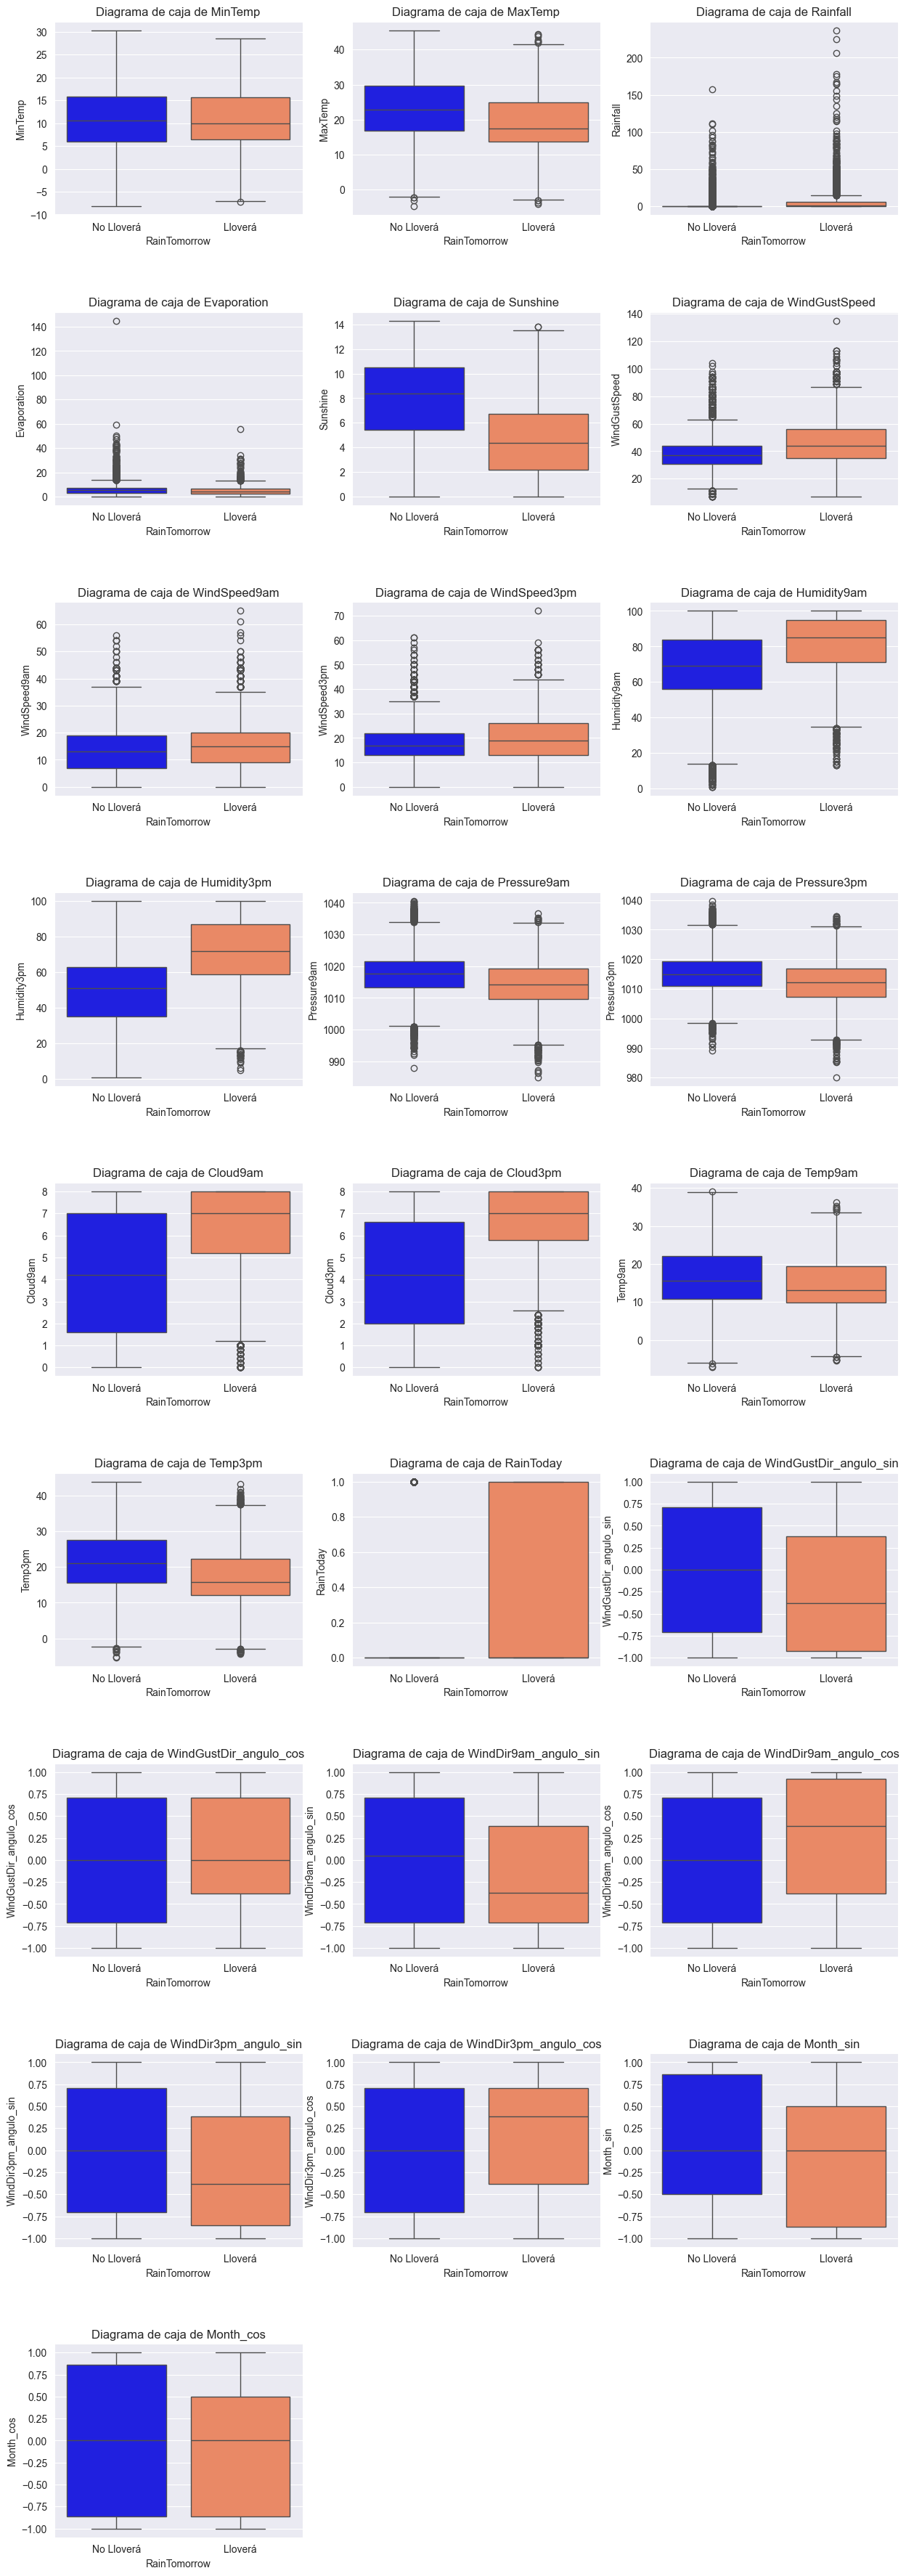

In [37]:
# Calculamos la frecuencia de cada valor
dataframe = pd.DataFrame(y_train)
value_counts = dataframe[0].value_counts().reset_index()
value_counts.columns = ['Valores', 'Frecuencia']
sns.barplot(x='Valores', y='Frecuencia', hue='Valores', data=value_counts, palette=['skyblue', 'salmon'])

# Agregar la cantidad de cada valor encima de cada barra
for index, row in value_counts.iterrows():
    plt.text(row.name, row['Frecuencia'] + 5, str(row['Frecuencia']), ha='center', va='bottom')

plt.title('Frecuencia de Yes y No')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

boxplots(x_train_imputer_v2, y_train, x_train_imputer_v2.columns)

Podemos observar a nivel general un gran desbalanceo de datos, alrededor de 3 veces más valores negativos (17119) que positivos (5188) en nuestra variable a predecir. En términos de nuestro dataset, la cantidad de días no lluviosos es mayor a la cantidad de días lluviosos.

Es importante saber si los datos están desbalanceados, ya que si no lo están, se provocar un sesgo en el modelo a entrenar. Esto se lo podrá observar en los valores de ``recall`` entre el modelo con datos balanceados y no balanceados. 

Con nuestro balance de datos actual, nuestro modelo sin balancear podría tener mayor tendencia de asignar "No" (No lloverá mañana) a los días que clasifique.

En general, si para ambas clases se observa un nivel de recall (por clase) del 80%, esto indicaría que se obtuvo un buen fitting.

### Escalado de Datos

Debido a que vimos variables con una gran cantidad de outliers decidimos usar un escalador mas robusto que no esté influenciado por los mismos

In [38]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer_v2)
x_test_scaled = scaler.transform(x_test_imputer_v2)

Luego de haber analizado los datos, codificado las variables y revisado los Nulls, podemos continuar con el entrenamiento de nuestros modelos.

# Ejercicio 2

## Regresión Logística

In [39]:
y_train_series = pd.Series(y_train).value_counts()
print(f"Distribución de los datos:\n Lloverá mañana: {y_train_series[1]}\n No lloverá mañana: {y_train_series[0]}\n Los registros en los que lloverá al día siguiente representan el {round(y_train_series[1]/(y_train_series[1] + y_train_series[0])*100,2)}% de los datos.")


Distribución de los datos:
 Lloverá mañana: 5248
 No lloverá mañana: 17218
 Los registros en los que lloverá al día siguiente representan el 23.36% de los datos.


C:\Users\rocio\AppData\Local\Temp\ipykernel_3444\252717250.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Distribución de los datos:\n Lloverá mañana: {y_train_series[1]}\n No lloverá mañana: {y_train_series[0]}\n Los registros en los que lloverá al día siguiente representan el {round(y_train_series[1]/(y_train_series[1] + y_train_series[0])*100,2)}% de los datos.")


Como ya habíamos determinado anteriormente, nuestro dataset se encuentra desbalanceado. Realizaremos nuestra regresión logística en estas condiciones, y luego implementaremos distintas técnicas de balanceo para comparar su rendimiento.

In [40]:
Y_train_nn = y_train.copy() #guardamos para su uso posterior

In [41]:
y_train = y_train.to_numpy().ravel() # Transformamos en un Numpy array de 1D

## Regresión Logística - Sin balancear

In [42]:
# Creamos el modelo de Regresión logística
logistic_model = LogisticRegression(random_state=42, max_iter=200) # Incrementamos las iteraciones así puede converger
logistic_model.fit(x_train_scaled, y_train)

y_pred = logistic_model.predict(x_test_scaled)

# Visualizamos las métricas
logRegMetrics(y_test,y_pred,'Regresión Logística (sin balanceo)')

Métricas para Regresión Logística (sin balanceo):

Accuracy: 0.8390599964393805

Matriz de confusión:
[[4025  277]
 [ 627  688]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4302
           1       0.71      0.52      0.60      1315

    accuracy                           0.84      5617
   macro avg       0.79      0.73      0.75      5617
weighted avg       0.83      0.84      0.83      5617



Si bien se obtuvo una ``Accuracy`` alta (0.84), esta métrica no es ideal para datasets desbalanceados. Esto se debe al sesgo que tendrá el modelo, ya que asignará la variable con más frecuencia (en este caso, "No") a una mayor cantidad de datos.

Además, se obtuvo un valor ``Recall`` de 0.94 para _No_ y 0.54 para _Yes_. ``Recall`` describe, dentro de una misma clase, cuántas fueron correctamente clasificadas.  
Esto también pone en evidencia el desbalance del dataset, ya que se obtuvo un muy buen valor de ``Recall`` para los negativos, pero no para los positivos.

En cuanto a la ``Precisión``, esta métrica mide cuántas de las clases clasificadas como positivas realmente lo son. Cuántos menos falsos positivos (FP), más alto será este valor. Podemos observar que la ``Precision`` para los valores negativos fue más alta que para los positivos, lo cual también se justifica con el desbalanceo del dataset.

En la matríz de confusión se observan: 
- TN (Verdaderos Negativos): 4030
- FP (Falsos positivos): 272
- FN (Falsos negativos): 609
- TP (Verdaderos positivos): 706


Umbral del punto más cercano a (0,1): 0.2208610532422647
Punto más cercano a (0,1): (0.21, 0.81)


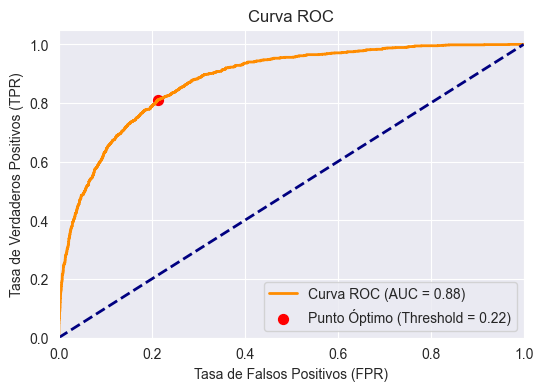

In [43]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logistic_model.predict_proba(x_test_scaled)[:, 1]

logistic_model_th = curvaRocCustom(y_test,y_probs)

In [44]:
y_pred_custom = (y_probs >= logistic_model_th).astype(int)

logRegMetrics(y_test,y_pred_custom,'Regresión Logística (sin balanceo - con umbral óptimo)')

Métricas para Regresión Logística (sin balanceo - con umbral óptimo):

Accuracy: 0.7922378493857931

Matriz de confusión:
[[3383  919]
 [ 248 1067]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      4302
           1       0.54      0.81      0.65      1315

    accuracy                           0.79      5617
   macro avg       0.73      0.80      0.75      5617
weighted avg       0.84      0.79      0.80      5617



Podemos observar que la cantidad de TP (Verdaderos positivos) ha aumentado drásticamente luego de la optimización de umbral (ha pasado de 706 a 1049). Sin embargo, también ha aumentado la cantidad de FP (Falsos positivos) lo cual impacta la métrica de ``Precisión`` para los positivos.

## Regresión Logística - Balanceo "Balanced"

In [45]:
# Creamos el modelo de Regresión logística
logistic_weight_balanced = LogisticRegression(random_state=42, class_weight='balanced', max_iter=200)
logistic_weight_balanced.fit(x_train_scaled, y_train)
y_pred = logistic_weight_balanced.predict(x_test_scaled)

logRegMetrics(y_test,y_pred,'Regresión Logística (balanceo "Balanced")')

Métricas para Regresión Logística (balanceo "Balanced"):

Accuracy: 0.7972227167527149

Matriz de confusión:
[[3435  867]
 [ 272 1043]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4302
           1       0.55      0.79      0.65      1315

    accuracy                           0.80      5617
   macro avg       0.74      0.80      0.75      5617
weighted avg       0.84      0.80      0.81      5617



Umbral del punto más cercano a (0,1): 0.49014275175516886
Punto más cercano a (0,1): (0.21, 0.8)


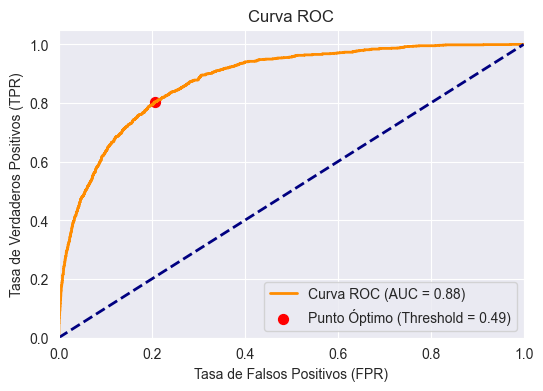

In [46]:
# Obtengo las probabilidades de predicción del modelo
y_probs2 = logistic_weight_balanced.predict_proba(x_test_scaled)[:, 1]

logistic_balanced_th = curvaRocCustom(y_test,y_probs2)


In [47]:
y_pred_custom = (y_probs2 >= logistic_balanced_th).astype(int)

logRegMetrics(y_test, y_pred_custom, 'Regresión Logística (balanceo "Balanced" - con umbral óptimo)')

Métricas para Regresión Logística (balanceo "Balanced" - con umbral óptimo):

Accuracy: 0.7957984689335944

Matriz de confusión:
[[3414  888]
 [ 259 1056]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      4302
           1       0.54      0.80      0.65      1315

    accuracy                           0.80      5617
   macro avg       0.74      0.80      0.75      5617
weighted avg       0.84      0.80      0.81      5617



## Regresión Logística - Balanceo SMOTE

In [48]:
# Balanceo con SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

In [49]:
logistic_SMOTE = LogisticRegression(random_state=42, max_iter=200)
logistic_SMOTE.fit(x_train_resampled, y_train_resampled)
y_pred = logistic_SMOTE.predict(x_test_scaled)

logRegMetrics(y_test, y_pred, 'Regresión Logística (balanceo SMOTE)')

Métricas para Regresión Logística (balanceo SMOTE):

Accuracy: 0.7997151504361759

Matriz de confusión:
[[3455  847]
 [ 278 1037]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4302
           1       0.55      0.79      0.65      1315

    accuracy                           0.80      5617
   macro avg       0.74      0.80      0.75      5617
weighted avg       0.84      0.80      0.81      5617



Umbral del punto más cercano a (0,1): 0.47002597933658186
Punto más cercano a (0,1): (0.22, 0.81)


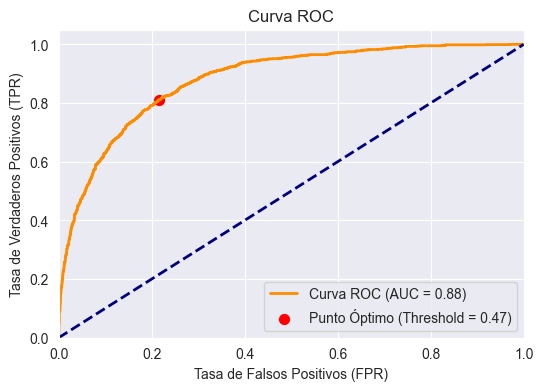

In [50]:
# Obtengo las probabilidades de predicción del modelo
y_probs3 = logistic_SMOTE.predict_proba(x_test_scaled)[:, 1]

logistic_SMOTE_th = curvaRocCustom(y_test,y_probs3)

In [51]:
y_pred_custom = (y_probs3 >= logistic_SMOTE_th).astype(int)

logRegMetrics(y_test, y_pred_custom, 'Regresión Logística (balanceo SMOTE - con umbral óptimo)')

Métricas para Regresión Logística (balanceo SMOTE - con umbral óptimo):

Accuracy: 0.7909916325440627

Matriz de confusión:
[[3376  926]
 [ 248 1067]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4302
           1       0.54      0.81      0.65      1315

    accuracy                           0.79      5617
   macro avg       0.73      0.80      0.75      5617
weighted avg       0.84      0.79      0.80      5617



# Ejercicio 3

## Modelo base

Para poder apreciar mejor el rendimiento de nuestros modelos, utilizaremos un modelo base, que realiza sus predicciones de una manera ingenua. Nos servirá de "base", justamente, ya que esperamos que sí o sí nuestro modelo tenga un mejor desempeño que el modelo base.

In [52]:
dummy_clf = DummyClassifier(strategy="stratified",random_state=42)
dummy_clf.fit(x_train_scaled, y_train)
dummy_pred = dummy_clf.predict(x_test_scaled)

logRegMetrics(y_test, dummy_pred, 'DummyClassifier')

Métricas para DummyClassifier:

Accuracy: 0.6371728680790457

Matriz de confusión:
[[3297 1005]
 [1033  282]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      4302
           1       0.22      0.21      0.22      1315

    accuracy                           0.64      5617
   macro avg       0.49      0.49      0.49      5617
weighted avg       0.63      0.64      0.64      5617



Utilizamos un ``DummyClassifier`` que genera predicciones sin utilizar ninguna relación entre las características de los datos y las etiquetas. En este caso,utilizamos la estrategia ``stratified``, lo que significa que las predicciones de la clase se asignan de manera aleatoria, pero respetando la distribución de clases de los datos de entrenamiento. 

Dado que se utilizó un ``DummyClassifier``, el desempeño no es representativo de un modelo real, ya que no aprende patrones significativos. Aunque se obtuvo una ``Accuracy`` de 0.64, esta métrica en este contexto no tiene mucho valor, ya que simplemente refleja la proporción de clases en los datos, sin que el modelo esté aprovechando ninguna información real.
Lo mismo ocurre con ``Recall``. Vemos que logra identificar correctamente el 77% de los casos de la clase mayoritaria ("No") pero solo el 21% de la clase minoritaria ("Yes"). Este resultado muestra la limitación del ``DummyClassifier``, que no tiene la capacidad de captar la clase minoritaria de manera efectiva.

En la matriz de confusión, vemos:

- TN (Verdaderos Negativos): 3297
- FP (Falsos Positivos): 1005
- FN (Falsos Negativos): 1033
- TP (Verdaderos Positivos): 282

Umbral del punto más cercano a (0,1): 1.0
Punto más cercano a (0,1): (0.23, 0.21)


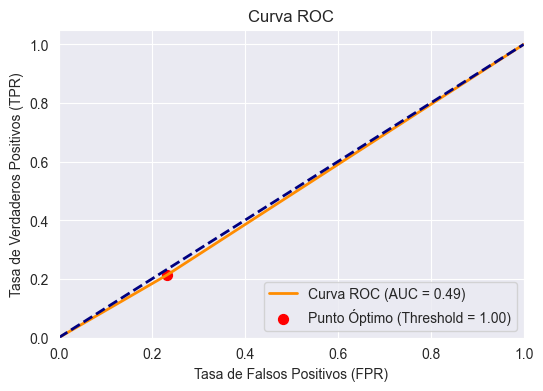

In [53]:
# Obtengo las probabilidades de predicción del modelo
y_probs_dummy = dummy_clf.predict_proba(x_test_scaled)[:, 1]

logistic_dummy_th = curvaRocCustom(y_test,y_probs_dummy)

El área debajo de la curva (AUC) dio 0.49. Esto ocurre cuando el modelo no tiene capacidad discriminativa, lo cual es correcto, ya que nuestro DummyClassifier está clasificando de manera totalmente aleatoria. 

In [54]:
y_pred_custom = (y_probs_dummy >= logistic_dummy_th).astype(int)

logRegMetrics(y_test, y_pred_custom, 'DummyClassifier (con umbral óptimo)')

Métricas para DummyClassifier (con umbral óptimo):

Accuracy: 0.6371728680790457

Matriz de confusión:
[[3297 1005]
 [1033  282]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      4302
           1       0.22      0.21      0.22      1315

    accuracy                           0.64      5617
   macro avg       0.49      0.49      0.49      5617
weighted avg       0.63      0.64      0.64      5617



# Conclusiones

Pudimos observar que al implementar el umbral óptimo en nuestros modelos, las metricas mejoran. Al elegir el punto que más se aproxima a (0,1), estamos optimizando el TPR, lo que nos da un modelo que predice mejor. También podemos determinar que, para modelos balanceados, un umbral cercano a 0.5 es el ideal. En el caso del modelo con los datos no balanceados, el umbral nos dio más cercano a 0, lo cual se explica, ya que nuestra variable a predecir presenta mayormente valores negativos que positivos.

En base a las matrices de confusión pudimos sacar las siguientes conclusiones:
- **Falsos Positivos (FP):** Estos son casos en los que el modelo predijo la clase positiva ("Yes") cuando en realidad era negativa ("No"). En el modelo sin balancear, debido a la consecuencia de tener mayor cantidad de valores negativos que positivos en nuestra variable respuesta, el número de falsos positivos es menor que en los modelos que utilizaron datos balanceados. Esto se debe a que el modelo sin balancear se ajusta mejor para los datos con mayor frecuencia. Entre los modelos balanceados se obtuvieron cantidades de falsos positivos similares.
- **Falsos Negativos (FN):** Estos son casos en los que el modelo predijo la clase negativa ("No") cuando en realidad era positiva ("Yes"). En este caso pasa lo opuesto a lo dicho anteriormente: en el modelo balanceado tienen la misma cantidad de falsos negativos que verdaderos positivos. Esto nos quiere decir que predijo mal el 50% de los valores positivos; se evidencia el desbalanceo mencionado anteriormente. Para los modelos balanceados podemos ver cómo el número de falsos negativos disminuye drásticamente, ya que son modelos que predicen mejor los valores positivos.

# Ejercicio 4

## Optimización de hiperparámetros

### K-folds

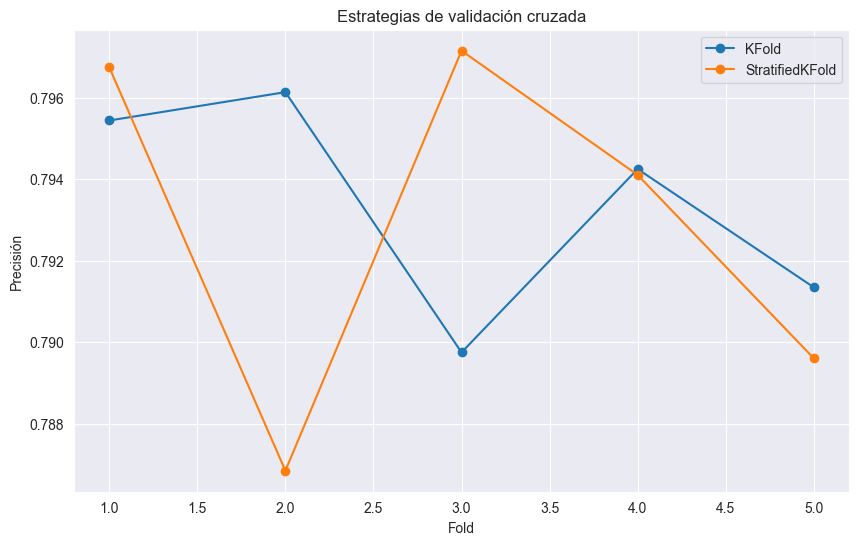

Media para la estrategia KFold: 0.7934
Desvío estándar para la estrategia KFold: 0.0024
Media para la estrategia StratifiedKFold: 0.7929
Desvío estándar para la estrategia StratifiedKFold: 0.0040


In [55]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, LeaveOneOut

# Estrategias de validación cruzada
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
]

# Almacenar los resultados
results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(logistic_SMOTE, x_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
    results[name] = scores

# Graficar los resultados
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Precisión")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

# Imprimir la media y el desvío estándar de cada estrategia
for name, scores in results.items():
    print(f"Media para la estrategia {name}: {scores.mean():.4f}")
    print(f"Desvío estándar para la estrategia {name}: {scores.std():.4f}")
    

Pomodes observar que luego de realizar las pruebas obtuvimos resultados positivos, es decir las métricas de nuestro modelo no se vio afectado a lo largo del los distintos entrenamientos. Esto demuestra que logramos obtener un modelo que no varia drasticamente segun los datos utilizados para su entrenamiento dandonos un modelo estable y que generaliza bien ya que su puntaje se mantiene alrededor de 0,79/0,80 y presenta un desvío estandar del 0.0022

In [56]:
# # Definimos el modelo de Regresión Logística
# logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced', max_iter=200)

# # Configuramos K-Folds
# kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Cambia n_splits para definir el número de particiones

# # Ejecutamos la validación cruzada con la métrica de precisión
# accuracy_scores = cross_val_score(logistic_SMOTE, x_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')
# precision_scores = cross_val_score(logistic_SMOTE, x_train_resampled, y_train_resampled, cv=kf, scoring='precision')
# recall_scores = cross_val_score(logistic_SMOTE, x_train_resampled, y_train_resampled, cv=kf, scoring='recall')
# f1_scores = cross_val_score(logistic_SMOTE, x_train_resampled, y_train_resampled, cv=kf, scoring='f1')

# # Mostramos los resultados promedio

### Grid-Search

Luego de una investigación de los posibles parametros a hoptimizar decidimos utilizar un metodo de gred search ya que se cuenta con pocos hiperparametros a definir, tambien se limito la cantidad de iteraciones hasta 300, ya que con 200 iteraciones observamos que pudimos obtener buenos resultados por ende por mas que mejore nuestro modelo teniendo mayor cantidad de iteraciones no lo tomaremos como una mejor opcion por el rendimiento y tiempo que conllevaría.

In [57]:
from sklearn.model_selection import GridSearchCV
import time
# Definimos los parámetros para Grid Search
param_grid = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'sag'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 300]},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.2, 0.5, 0.7], 'max_iter': [100, 200, 300]},
    {'penalty': [None], 'solver': ['lbfgs', 'sag'], 'max_iter': [100, 200, 300]}
]

# Realizamos la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(estimator=logistic_SMOTE, param_grid=param_grid, cv=5, n_jobs=-1)
start = time.time()
grid_search.fit(x_train_resampled, y_train_resampled)
end = time.time()
grid_search_time = end - start
y_pred_grid_search = grid_search.predict(x_test_scaled)

# Métricas para el modelo con Grid Search
grid_search_accuracy = accuracy_score(y_test, y_pred_grid_search)
grid_search_precision = precision_score(y_test, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test, y_pred_grid_search, average='weighted')
grid_search_f1_score = f1_score(y_test, y_pred_grid_search, average='weighted')

### Explicación de los hiperparámetros a optimizar

1. **Hiperparámetro `penalty`**
- **Descripción**: Define el tipo de regularización que se aplicará al modelo. Puede tomar los valores:
  - `l2`: Penaliza la suma de los cuadrados de los coeficientes, lo que tiende a reducir coeficientes grandes pero mantiene todos no nulos.
  - `l1`: Penaliza la suma de los valores absolutos de los coeficientes, lo que tiende a hacer que algunos coeficientes sean exactamente cero (útil para selección de características).
  - `elasticnet`: Combina \( l1 \) y \( l2 \) con un balance controlado por el parámetro `l1_ratio`.
  - `None`: No aplica penalización.
- **Justificación**: Probar diferentes penalizaciones ayuda a determinar si la regularización mejora el rendimiento del modelo, especialmente cuando no se observa sobreajuste.


2. **Hiperparámetro `C`**
- **Descripción**: Controla la **intensidad de la regularización**. Es inversamente proporcional a la fuerza de regularización:
  - Valores bajos (\( C = 0.01, 0.1 \)): Más regularización.
  - Valores altos (\( C = 10, 100 \)): Menos regularización.
- **Justificación**: 
  - No se ha identificado un problema de sobreajuste en los datos, por lo que se espera que valores más altos de \( C \) (menor regularización) proporcionen un mejor ajuste.
  - Sin embargo, incluir valores bajos permite evaluar cómo responde el modelo a una penalización más estricta.


3. **Hiperparámetro `solver`**
- **Descripción**: Especifica el algoritmo para optimizar la función de pérdida. Los seleccionados son:
  - `lbfgs`: Algoritmo eficiente para problemas de regresión logística con \( l2 \).
  - `sag`: Descenso estocástico acelerado, adecuado para grandes datasets.
  - `liblinear`: Algoritmo para penalización \( l1 \) o \( l2 \), pero solo funciona en problemas binarios.
  - `saga`: Similar a `sag` pero compatible con \( l1 \) y elasticnet.
- **Justificación**: Cada solver tiene fortalezas específicas dependiendo del tamaño del dataset y el tipo de penalización, por lo que la elección afecta tanto la velocidad como la estabilidad de la convergencia.


4. **Hiperparámetro `max_iter`**
- **Descripción**: Número máximo de iteraciones para que el solver converja.
- **Justificación**: Si el solver no converge con un valor bajo (por ejemplo, 100), permitir más iteraciones (200 o 300) puede mejorar el ajuste.


5. **Hiperparámetro `l1_ratio` (para `elasticnet`)**
- **Descripción**: Proporción entre \( l1 \) y \( l2 \) en la penalización elasticnet:
  - \( l1\_ratio = 0.2 \): Más peso al término \( l2 \).
  - \( l1\_ratio = 0.7 \): Más peso al término \( l1 \).
- **Justificación**: Este parámetro permite ajustar el balance entre regularización fuerte y selección de características. Probar valores intermedios ayuda a determinar la mejor combinación para los datos.


Se espera de este test que:
- Las combinaciones con penalización \( l2 \) y valores altos de \( C \) probablemente funcionen mejor, dado que no se ha observado sobreajuste.
- Penalizaciones como \( l1 \) o `elasticnet` son útiles para validar si se puede obtener un modelo con menos coeficientes no nulos, especialmente si hay ruido o variables irrelevantes.
- Resolver con `None` (sin penalización) permite comparar el rendimiento frente a las opciones regularizadas.

Este enfoque permite explorar una amplia variedad de configuraciones y garantiza que se seleccionará la mejor combinación de hiperparámetros para los datos en cuestión.


In [58]:
grid_search.best_params_

{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Análisis de los parámetros seleccionados


C = 10
Este valor indica una regularización moderada, ya que un 𝐶 alto reduce la fuerza de regularización. Esto confirma que el modelo no requería una penalización estricta, probablemente debido a que los datos no presentan problemas significativos de sobreajuste.

max_iter = 100
El solver logró converger con un número estándar de iteraciones, lo que indica que el modelo se ajustó bien dentro del límite definido. No fue necesario aumentar este valor, lo que sugiere que el conjunto de datos y la configuración seleccionada son computacionalmente eficientes.

penalty = 'l2'
La penalización 𝑙2 fue la mejor opción para este caso. Al penalizar la suma de los cuadrados de los coeficientes, se priorizó mantener coeficientes más pequeños sin hacerlos exactamente cero. Este tipo de regularización es ideal para problemas donde no es necesaria una selección estricta de características.

solver = 'lbfgs'
Este solver es eficiente y adecuado para problemas de regresión logística con 𝑙2. Funciona bien con tamaños de dataset pequeños a medianos y garantiza estabilidad en la convergencia.

In [59]:
y_pred = grid_search.predict(x_test_scaled)
logRegMetrics(y_test, y_pred, 'Regresión Logística (balanceo SMOTE - optimización HP)')

Métricas para Regresión Logística (balanceo SMOTE - optimización HP):

Accuracy: 0.7998931814135659

Matriz de confusión:
[[3456  846]
 [ 278 1037]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4302
           1       0.55      0.79      0.65      1315

    accuracy                           0.80      5617
   macro avg       0.74      0.80      0.75      5617
weighted avg       0.84      0.80      0.81      5617



Podemos observar como optimizar los hiperparametros contribuyo a mejorar el accueracy del modelo de un 0.6 a un 0.8 

# Ejercicio 5

## Interpretabilidad **local**

In [60]:
feature_names=x_train_imputer_v2.columns.values

In [61]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(logistic_SMOTE, x_train_resampled, feature_names=feature_names)
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(x_test_scaled)
shap_values.shape

(5617, 25)

In [62]:
index=0
logistic_SMOTE.predict_proba(x_test_scaled)[index]
logistic_SMOTE.predict(x_test_scaled)[index]

0

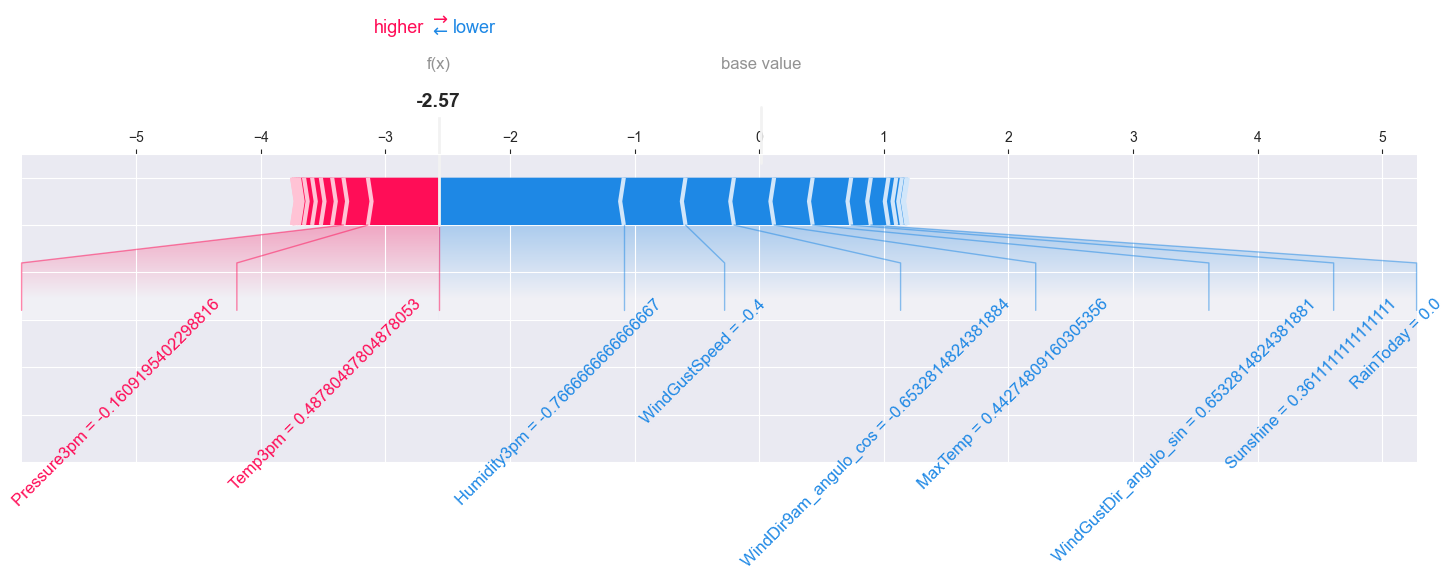

In [63]:
shap.force_plot(explainer.expected_value, shap_values[index],
                x_test_scaled[index], feature_names=feature_names,
                matplotlib=True, figsize=(18, 4), text_rotation=45)

In [64]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)

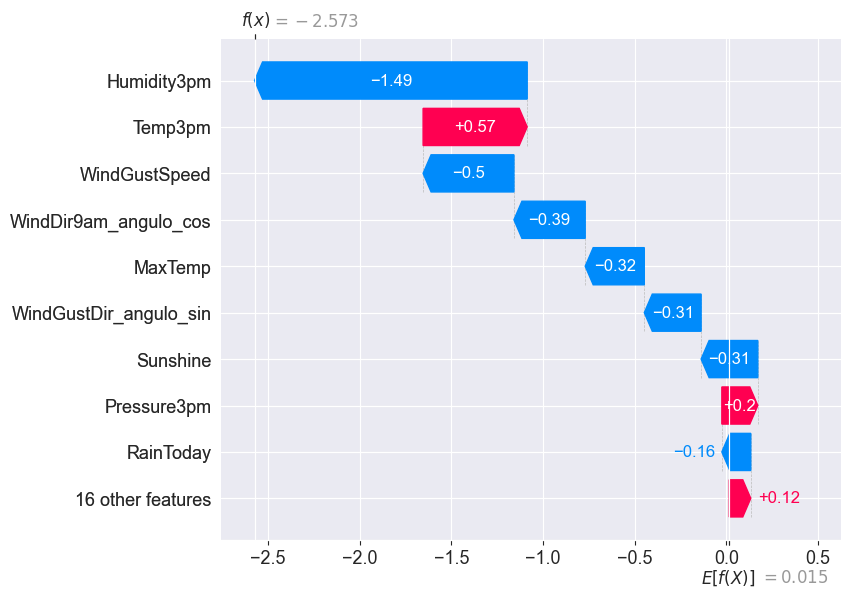

In [65]:
shap.plots.waterfall(explanation)

Se observa como tener valores de humedad 3pm hizo que empujara fuertemente a tener una prediccion negativa, podriamos decir que fue casi unanime que todas las variables empujan para una prediccion negativa, salvo temp 3pm pressure 3pm y la suma de las 16 variables restantes.

## Interpretabilidad **global**

In [66]:
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    feature_names=feature_names,
    data=x_test_scaled  
)

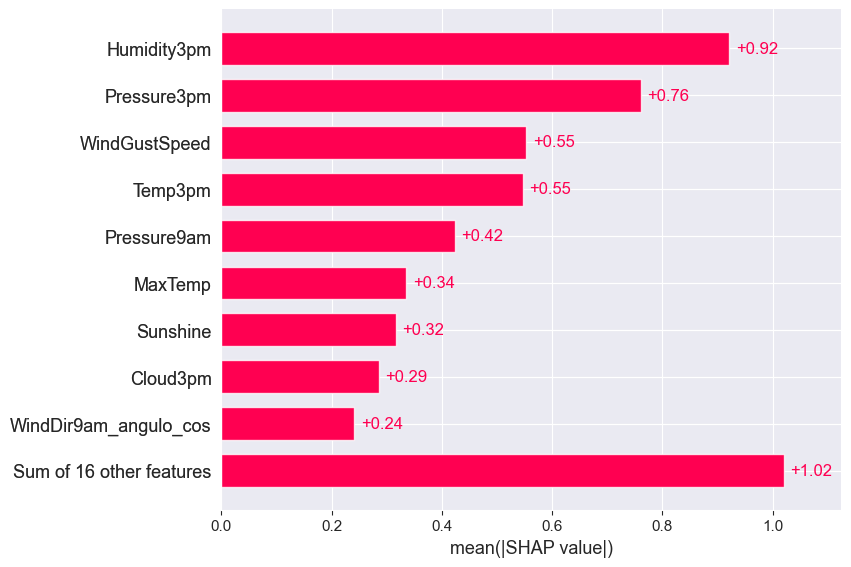

In [67]:
shap.plots.bar(explanation)

Podemos observar como las variables que mas pesan a la hora de predecir si mañana llueve o no es humedad y presion a las 3 pm. La variable humedad3pm contribuye casi de la misma forma que la sumatoria de los 16 feuters restantes.

Debemos asegurarnos que las dimensiones coincidan

In [68]:
print(shap_values.shape)  
print(x_test_scaled.shape)  

(5617, 25)
(5617, 25)


In [69]:
x_test_imputer_v2['RainToday'].value_counts()

RainToday
0.0    4283
1.0    1334
Name: count, dtype: int64

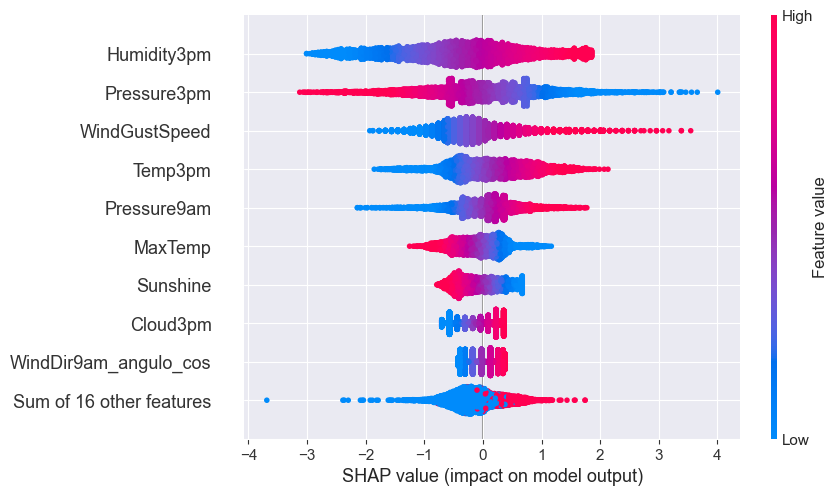

In [70]:
shap.plots.beeswarm(explanation)

En el gráfico podemos determinar como para valores superiores en las variables humedad, windguestspeed, pressure9am, temp3pm contribuyen a que la prediccion de que el dia siguiente sea de lluvia, mientras que pressure3pm, maxtemp y sunshine deben tener valores bajos para apoyar esa prediccion. Se puede observar tambien distribuciones aproximadamente normales, aunque en casos como windgustspeed tiene una asimetria hacia la izquierda. 

# Ejercicio 6

In [71]:
#pip install pycaret

In [72]:
from pycaret.classification import *
x = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(x, y, test_size=0.2, random_state=42)
clf = setup(data = X_train_model, target = y_train_model, fix_imbalance=True, fix_imbalance_method=SMOTE())

,Description,Value
0,Session id,304
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(22466, 22)"
4,Transformed data shape,"(30844, 69)"
5,Transformed train set shape,"(24104, 69)"
6,Transformed test set shape,"(6740, 69)"
7,Numeric features,16
8,Date features,1
9,Categorical features,4


Este conjunto de datos es un resumen de la configuración que utilizó PyCaret para el entrenamiento de los modelo.
Notamos algunas particularidades:
- El número de variables ha aumentado de 22 a 69, esto se condice con que según "Maximum one-hot encoding", que menciona que hay hasta 25 caracteristicas que pueden ser codificadas.
- Se está utilizando StratifiedKFold, lo que es útil cuando el conjunto de datos está desequilibrado. Se utilizaron 10 pliegues.
- Pycaret identifica que faltan datos en el 62.8% de las filas.

In [73]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8448,0.8817,0.5762,0.7062,0.6342,0.5370,0.5418,0.7130
rf,Random Forest Classifier,0.8432,0.8795,0.5975,0.6900,0.6401,0.5406,0.5430,1.3310
et,Extra Trees Classifier,0.8408,0.8752,0.5449,0.7066,0.6148,0.5167,0.5240,1.0410
gbc,Gradient Boosting Classifier,0.8332,0.8710,0.6288,0.6480,0.6378,0.5296,0.5300,2.7230
ada,Ada Boost Classifier,0.8113,0.8469,0.6459,0.5882,0.6151,0.4906,0.4920,0.8500
ridge,Ridge Classifier,0.7888,0.8643,0.7659,0.5337,0.6288,0.4878,0.5035,0.1500
lda,Linear Discriminant Analysis,0.7879,0.8646,0.7668,0.5322,0.6281,0.4865,0.5025,0.2430
lr,Logistic Regression,0.7861,0.8653,0.7755,0.5292,0.6288,0.4861,0.5039,2.1290
dt,Decision Tree Classifier,0.7690,0.6948,0.5555,0.5055,0.5292,0.3766,0.3774,0.3070
dummy,Dummy Classifier,0.7664,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1120


Resulta notorio que el modelo de LogisticRegression utilizado por pycarat lográ mejores resultados que los que hemos optimizado nosotros en este trabajo práctico.
El mejor modelo encontrado por pycaret es Light Gradient Boosting Machine

In [74]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [75]:
final_model = finalize_model(best_model)
y_pred = predict_model(final_model, data=X_test_model)

# Calcular métricas
print("Accuracy:", accuracy_score(y_test_model, y_pred['prediction_label']))
print("Confusion Matrix:\n", confusion_matrix(y_test_model, y_pred['prediction_label']))
print("Classification Report:\n", classification_report(y_test_model, y_pred['prediction_label']))

Accuracy: 0.8543706604949262
Confusion Matrix:
 [[4002  300]
 [ 518  797]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4302
           1       0.73      0.61      0.66      1315

    accuracy                           0.85      5617
   macro avg       0.81      0.77      0.78      5617
weighted avg       0.85      0.85      0.85      5617



Podemos observar que el modelo generado tiene una mayor accueracy y predijo con un 93% los valores negativos, dando el mayor puntaje de todos los modelos, pero el mismo pierde contra predecir los valores positivos de lluvia el día siguiente.

In [76]:
x_test_scaled_df_model = pd.DataFrame(x_test_scaled, columns=x_test_imputer_v2.columns)
x_test_scaled_df_model2 = pd.DataFrame(x_train_resampled, columns=x_test_imputer_v2.columns)
clf2 = setup(data = x_test_scaled_df_model2, target = y_train_resampled)
best_model2 = compare_models()

,Description,Value
0,Session id,2110
1,Target,target
2,Target type,Binary
3,Original data shape,"(34436, 26)"
4,Transformed data shape,"(34436, 26)"
5,Transformed train set shape,"(24105, 26)"
6,Transformed test set shape,"(10331, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9066,0.9677,0.9252,0.8921,0.9083,0.8132,0.8138,0.6120
lightgbm,Light Gradient Boosting Machine,0.8961,0.9635,0.8779,0.9111,0.8942,0.7922,0.7928,0.3560
rf,Random Forest Classifier,0.8928,0.9606,0.9007,0.8867,0.8936,0.7855,0.7857,1.4870
gbc,Gradient Boosting Classifier,0.8687,0.9416,0.8679,0.8693,0.8686,0.7374,0.7374,2.2420
knn,K Neighbors Classifier,0.8371,0.9147,0.9426,0.7784,0.8527,0.6743,0.6898,0.2100
ada,Ada Boost Classifier,0.8287,0.9113,0.8331,0.8259,0.8295,0.6574,0.6575,0.5220
dt,Decision Tree Classifier,0.8094,0.8094,0.8212,0.8024,0.8116,0.6188,0.6192,0.1470
lr,Logistic Regression,0.7920,0.8738,0.7896,0.7935,0.7914,0.5839,0.5840,0.0560
ridge,Ridge Classifier,0.7911,0.8729,0.7893,0.7922,0.7907,0.5822,0.5824,0.0250
lda,Linear Discriminant Analysis,0.7911,0.8729,0.7892,0.7923,0.7906,0.5822,0.5823,0.0320


In [77]:
final_model2 = finalize_model(best_model2)

y_pred2 = predict_model(final_model2, data=x_test_scaled_df_model)

# Calcular métricas
print("Accuracy:", accuracy_score(y_test, y_pred2['prediction_label']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred2['prediction_label']))
print("Classification Report:\n", classification_report(y_test, y_pred2['prediction_label']))

Accuracy: 0.846181235534983
Confusion Matrix:
 [[3911  391]
 [ 473  842]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      4302
           1       0.68      0.64      0.66      1315

    accuracy                           0.85      5617
   macro avg       0.79      0.77      0.78      5617
weighted avg       0.84      0.85      0.84      5617



In [78]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

# Ejercicio 7

In [79]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        #inicializo algunos parámetros como épocas, batch_size, learning rate
        #(no son necesarios)
        #se puede agregar la cantidad de capas, la cantidad de neuronas por capa (pensando en hacer una clase que pueda ser usada para cualquier caso)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None
    

    ### VERSION 1
    # def build_model(self, input_shape, num_classes):
    #     # El modelo ahora está preparado para clasificación binaria
    #     model = tf.keras.models.Sequential([
    #         # Capas ocultas
    #         tf.keras.layers.Dense(30, activation='relu', input_shape=(input_shape,)),
    #         #tf.keras.layers.Dropout(0.3),  # Dropout para evitar sobreajuste
    #         tf.keras.layers.Dense(26, activation='relu'),
    #         #tf.keras.layers.Dropout(0.3),  # Dropout para evitar sobreajuste
    #         tf.keras.layers.Dense(24, activation='relu'),
    #         #tf.keras.layers.Dropout(0.3),  # Dropout para evitar sobreajuste

            
    #         # Capa de salida con una sola neurona (sigmoide) para clasificación binaria
    #         tf.keras.layers.Dense(1, activation='sigmoid')
    #     ])

    #     # Compilación del modelo con Adam y binary_crossentropy para clasificación binaria
    #     optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    #     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    #     self.model = model

    from tensorflow.keras import regularizers

    def build_model(self, input_shape):
        # Definir el modelo con 3 capas ocultas
        model = tf.keras.models.Sequential([
            # Capa densa con regularización L2
            tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.3),  # Dropout para evitar sobreajuste
            tf.keras.layers.Dense(26, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.3),
            # Capa de salida con sigmoide para clasificación binaria
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        # Ajustar la tasa de aprendizaje
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Reducir la tasa de aprendizaje si es necesario
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Función de pérdida binaria

        self.model = model



    def fit(self, X_train, y_train, X_valid, y_valid):
        # simplemente el fit del modelo. Devuelvo la evolución de la función de pérdida, ya que es interesante ver como varía a medida que aumentan las épocas!
        history=self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=self.epochs, batch_size=self.batch_size)
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        ### evalúo en test
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"test accuracy: {accuracy:.4f}")

    def predict(self, X_new):
        ### predicciones
        predictions = self.model.predict(X_new)
        return predictions


In [81]:
nn = NeuralNetwork(epochs=50, batch_size=64, learning_rate=0.05)

X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(x_train_scaled, Y_train_nn, test_size=0.2, random_state=42)

#buildeo el modelo
#nn.build_model(input_shape=X_train_nn.shape[1], num_classes=y_train_nn.shape[1])
nn.build_model(input_shape=X_train_nn.shape[1])
# entreno el modelo
history=nn.fit(X_train_nn, y_train_nn, X_valid_nn, y_valid_nn)

# evaluo metricas
nn.evaluate(x_test_scaled, y_test)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6907 - loss: 1.2373 - val_accuracy: 0.7939 - val_loss: 0.6714
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8000 - loss: 0.6409 - val_accuracy: 0.8151 - val_loss: 0.5143
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8029 - loss: 0.5222 - val_accuracy: 0.8313 - val_loss: 0.4594
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8166 - loss: 0.4674 - val_accuracy: 0.8291 - val_loss: 0.4357
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8283 - loss: 0.4396 - val_accuracy: 0.8313 - val_loss: 0.4215
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8259 - loss: 0.4339 - val_accuracy: 0.8309 - val_loss: 0.4168
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8258 - loss: 0.4261 - val_accuracy: 0.8333 - val_loss: 0.4143
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8292 - loss: 0.4270 - val_accuracy: 0.

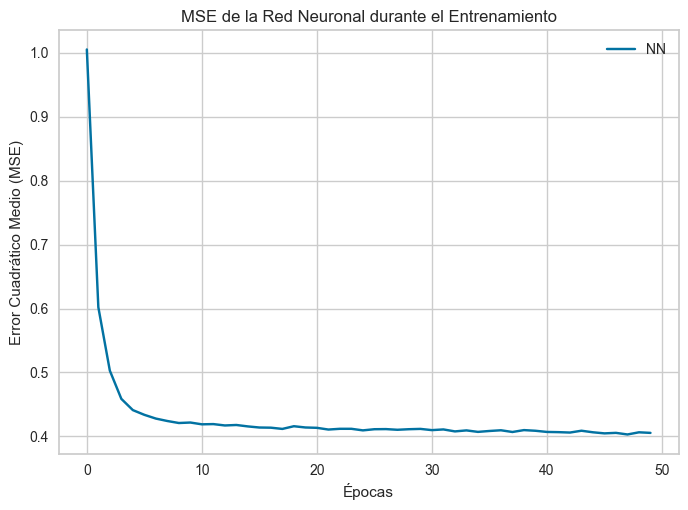

In [ ]:
plt.plot(history, label='NN')
plt.xlabel('Épocas')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE de la Red Neuronal durante el Entrenamiento')
plt.legend()
plt.show()

In [83]:
import optuna

# Función objetivo para Optuna
def objective(trial):
    # Sugerimos los hiperparámetros a optimizar
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Crear el modelo con los hiperparámetros sugeridos
    nn = NeuralNetwork(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
    nn.build_model(input_shape=X_train_nn.shape[1])

    # Entrenar el modelo
    loss, val_loss = nn.fit(X_train_nn, y_train_nn, X_valid_nn, y_valid_nn)
    
    # Optuna busca minimizar esta métrica, así que devolvemos la pérdida final de validación
    return val_loss[-1]

# Crear un estudio Optuna
study = optuna.create_study(direction="minimize")  # Minimizar la pérdida de validación
study.optimize(objective, n_trials=20)  # Número de intentos

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)
print("Mejor valor de pérdida:", study.best_value)


[I 2024-11-27 00:26:07,875] A new study created in memory with name: no-name-68d3ff28-b30c-402f-af17-cfd54d55eb55


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7536 - loss: 1.0495 - val_accuracy: 0.8251 - val_loss: 0.5248
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8138 - loss: 0.5116 - val_accuracy: 0.8333 - val_loss: 0.4389
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8249 - loss: 0.4522 - val_accuracy: 0.8340 - val_loss: 0.4183
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8324 - loss: 0.4270 - val_accuracy: 0.8309 - val_loss: 0.4124
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8289 - loss: 0.4204 - val_accuracy: 0.8282 - val_loss: 0.4121
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8216 - loss: 0.4226 - val_accuracy: 0.8333 - val_loss: 0.4058
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8270 - loss: 0.4197 - val_accuracy: 0.8351 - val_loss: 0.4059
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8316 - loss: 0.4190 - val_accuracy: 0.

[I 2024-11-27 00:34:13,405] Trial 0 finished with value: 0.3934071660041809 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0012972486538960959}. Best is trial 0 with value: 0.3934071660041809.


Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7582 - loss: 1.1609 - val_accuracy: 0.7926 - val_loss: 0.6452
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7932 - loss: 0.6266 - val_accuracy: 0.8075 - val_loss: 0.5057
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8051 - loss: 0.4964 - val_accuracy: 0.8267 - val_loss: 0.4559
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8210 - loss: 0.4601 - val_accuracy: 0.8269 - val_loss: 0.4358
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8195 - loss: 0.4467 - val_accuracy: 0.8278 - val_loss: 0.4257
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8263 - loss: 0.4322 - val_accuracy: 0.8316 - val_loss: 0.4195
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8226 - loss: 0.4344 - val_accuracy: 0.8313 - val_loss: 0.4116
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8299 - loss: 0.4224 - val_accuracy: 0.

[I 2024-11-27 00:34:36,238] Trial 1 finished with value: 0.39750680327415466 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.0008236487820346613}. Best is trial 0 with value: 0.3934071660041809.


Epoch 1/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7732 - loss: 1.1335 - val_accuracy: 0.8037 - val_loss: 0.5874
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.5650 - val_accuracy: 0.8231 - val_loss: 0.4785
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8167 - loss: 0.4795 - val_accuracy: 0.8264 - val_loss: 0.4398
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8130 - loss: 0.4599 - val_accuracy: 0.8258 - val_loss: 0.4261
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8235 - loss: 0.4331 - val_accuracy: 0.8278 - val_loss: 0.4202
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8238 - loss: 0.4271 - val_accuracy: 0.8318 - val_loss: 0.4112
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8286 - loss: 0.4196 - val_accuracy: 0.8316 - val_loss: 0.4100
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8274 - loss: 0.4283 - val_accuracy: 0.

[I 2024-11-27 00:35:02,818] Trial 2 finished with value: 0.402721643447876 and parameters: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.0032874665576018043}. Best is trial 0 with value: 0.3934071660041809.


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7454 - loss: 1.1325 - val_accuracy: 0.8182 - val_loss: 0.5802
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8042 - loss: 0.5762 - val_accuracy: 0.8251 - val_loss: 0.4763
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8131 - loss: 0.4805 - val_accuracy: 0.8302 - val_loss: 0.4414
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8221 - loss: 0.4499 - val_accuracy: 0.8322 - val_loss: 0.4235
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8259 - loss: 0.4309 - val_accuracy: 0.8324 - val_loss: 0.4119
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8265 - loss: 0.4253 - val_accuracy: 0.8316 - val_loss: 0.4131
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8292 - loss: 0.4207 - val_accuracy: 0.8351 - val_loss: 0.4076
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8235 - loss: 0.4269 - val_accuracy: 0.

[I 2024-11-27 00:36:23,053] Trial 3 finished with value: 0.391374796628952 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0004880275705249783}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7193 - loss: 1.1736 - val_accuracy: 0.7833 - val_loss: 0.6524
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7946 - loss: 0.6242 - val_accuracy: 0.8055 - val_loss: 0.5080
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7955 - loss: 0.5183 - val_accuracy: 0.8244 - val_loss: 0.4570
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8136 - loss: 0.4701 - val_accuracy: 0.8240 - val_loss: 0.4359
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8190 - loss: 0.4501 - val_accuracy: 0.8302 - val_loss: 0.4241
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8259 - loss: 0.4296 - val_accuracy: 0.8296 - val_loss: 0.4151
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8201 - loss: 0.4312 - val_accuracy: 0.8313 - val_loss: 0.4121
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8261 - loss: 0.4283 - val_accuracy: 0.

[I 2024-11-27 00:36:50,279] Trial 4 finished with value: 0.39759910106658936 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.0006387148884063262}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6982 - loss: 1.2424 - val_accuracy: 0.8064 - val_loss: 0.6586
Epoch 2/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7976 - loss: 0.6278 - val_accuracy: 0.8271 - val_loss: 0.5076
Epoch 3/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8114 - loss: 0.5076 - val_accuracy: 0.8313 - val_loss: 0.4574
Epoch 4/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8171 - loss: 0.4710 - val_accuracy: 0.8329 - val_loss: 0.4324
Epoch 5/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8251 - loss: 0.4475 - val_accuracy: 0.8313 - val_loss: 0.4222
Epoch 6/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8243 - loss: 0.4450 - val_accuracy: 0.8327 - val_loss: 0.4164
Epoch 7/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8254 - loss: 0.4255 - val_accuracy: 0.8318 - val_loss: 0.4132
Epoch 8/40
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8272 - loss: 0.4346 - val_accuracy: 0.

[I 2024-11-27 00:37:26,029] Trial 5 finished with value: 0.40124189853668213 and parameters: {'epochs': 40, 'batch_size': 64, 'learning_rate': 0.00044436567392595503}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6970 - loss: 1.2196 - val_accuracy: 0.7960 - val_loss: 0.6419
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7933 - loss: 0.6167 - val_accuracy: 0.8111 - val_loss: 0.4998
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8064 - loss: 0.5000 - val_accuracy: 0.8200 - val_loss: 0.4524
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8139 - loss: 0.4618 - val_accuracy: 0.8287 - val_loss: 0.4310
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8242 - loss: 0.4432 - val_accuracy: 0.8309 - val_loss: 0.4218
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8212 - loss: 0.4377 - val_accuracy: 0.8284 - val_loss: 0.4149
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8276 - loss: 0.4230 - val_accuracy: 0.8322 - val_loss: 0.4121
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8238 - loss: 0.4352 - val_accuracy: 0.

[I 2024-11-27 00:37:45,012] Trial 6 finished with value: 0.4004577398300171 and parameters: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.00041190072592891375}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7206 - loss: 0.9708 - val_accuracy: 0.8280 - val_loss: 0.4729
Epoch 2/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8139 - loss: 0.4760 - val_accuracy: 0.8287 - val_loss: 0.4307
Epoch 3/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8199 - loss: 0.4502 - val_accuracy: 0.8291 - val_loss: 0.4143
Epoch 4/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8266 - loss: 0.4332 - val_accuracy: 0.8282 - val_loss: 0.4145
Epoch 5/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8261 - loss: 0.4288 - val_accuracy: 0.8298 - val_loss: 0.4125
Epoch 6/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8239 - loss: 0.4284 - val_accuracy: 0.8244 - val_loss: 0.4124
Epoch 7/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8263 - loss: 0.4219 - val_accuracy: 0.8327 - val_loss: 0.4076
Epoch 8/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8215 - loss: 0.4300 - 

[I 2024-11-27 00:40:09,482] Trial 7 finished with value: 0.40094876289367676 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.00040767728005256177}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7502 - loss: 1.1363 - val_accuracy: 0.8028 - val_loss: 0.5761
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7929 - loss: 0.5681 - val_accuracy: 0.8178 - val_loss: 0.4787
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8069 - loss: 0.4871 - val_accuracy: 0.8242 - val_loss: 0.4421
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8190 - loss: 0.4444 - val_accuracy: 0.8287 - val_loss: 0.4271
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8188 - loss: 0.4370 - val_accuracy: 0.8316 - val_loss: 0.4150
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8268 - loss: 0.4244 - val_accuracy: 0.8280 - val_loss: 0.4145
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8255 - loss: 0.4226 - val_accuracy: 0.8293 - val_loss: 0.4117
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8261 - loss: 0.4235 - val_accuracy: 0.

[I 2024-11-27 00:41:27,414] Trial 8 finished with value: 0.3972187936306 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0025371989398782695}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7699 - loss: 0.9227 - val_accuracy: 0.8160 - val_loss: 0.4692
Epoch 2/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8105 - loss: 0.4660 - val_accuracy: 0.8242 - val_loss: 0.4287
Epoch 3/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8244 - loss: 0.4284 - val_accuracy: 0.8287 - val_loss: 0.4153
Epoch 4/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8263 - loss: 0.4256 - val_accuracy: 0.8318 - val_loss: 0.4114
Epoch 5/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8276 - loss: 0.4200 - val_accuracy: 0.8340 - val_loss: 0.4069
Epoch 6/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8213 - loss: 0.4240 - val_accuracy: 0.8280 - val_loss: 0.4095
Epoch 7/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8287 - loss: 0.4207 - val_accuracy: 0.8338 - val_loss: 0.4065
Epoch 8/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8216 - loss: 0.4222 - 

[I 2024-11-27 00:42:00,416] Trial 9 finished with value: 0.41064441204071045 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.00016672641889053916}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7459 - loss: 1.0941 - val_accuracy: 0.7839 - val_loss: 0.5834
Epoch 2/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7896 - loss: 0.5670 - val_accuracy: 0.8198 - val_loss: 0.4714
Epoch 3/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8068 - loss: 0.4814 - val_accuracy: 0.8233 - val_loss: 0.4360
Epoch 4/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8229 - loss: 0.4414 - val_accuracy: 0.8282 - val_loss: 0.4207
Epoch 5/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8220 - loss: 0.4339 - val_accuracy: 0.8282 - val_loss: 0.4166
Epoch 6/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8267 - loss: 0.4261 - val_accuracy: 0.8318 - val_loss: 0.4120
Epoch 7/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8243 - loss: 0.4261 - val_accuracy: 0.8302 - val_loss: 0.4084
Epoch 8/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8280 - loss: 0.4162 - val_accuracy: 0.

[I 2024-11-27 00:43:10,476] Trial 10 finished with value: 0.39510899782180786 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.009444659667440422}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7464 - loss: 1.0498 - val_accuracy: 0.8117 - val_loss: 0.5275
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8083 - loss: 0.5152 - val_accuracy: 0.8264 - val_loss: 0.4473
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8167 - loss: 0.4577 - val_accuracy: 0.8331 - val_loss: 0.4238
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8186 - loss: 0.4429 - val_accuracy: 0.8273 - val_loss: 0.4159
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8286 - loss: 0.4243 - val_accuracy: 0.8296 - val_loss: 0.4128
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8242 - loss: 0.4291 - val_accuracy: 0.8311 - val_loss: 0.4116
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8252 - loss: 0.4196 - val_accuracy: 0.8340 - val_loss: 0.4077
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8288 - loss: 0.4244 - val_accuracy: 0.

[I 2024-11-27 00:44:43,857] Trial 11 finished with value: 0.3932771682739258 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0014799221655589828}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7459 - loss: 1.1222 - val_accuracy: 0.7775 - val_loss: 0.5836
Epoch 2/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7871 - loss: 0.5664 - val_accuracy: 0.8231 - val_loss: 0.4794
Epoch 3/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8086 - loss: 0.4878 - val_accuracy: 0.8249 - val_loss: 0.4423
Epoch 4/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8171 - loss: 0.4482 - val_accuracy: 0.8278 - val_loss: 0.4266
Epoch 5/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8189 - loss: 0.4473 - val_accuracy: 0.8322 - val_loss: 0.4182
Epoch 6/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8288 - loss: 0.4256 - val_accuracy: 0.8260 - val_loss: 0.4216
Epoch 7/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8258 - loss: 0.4319 - val_accuracy: 0.8278 - val_loss: 0.4173
Epoch 8/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8249 - loss: 0.4309 - val_accuracy: 0.

[I 2024-11-27 00:46:06,112] Trial 12 finished with value: 0.40395063161849976 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.00012353112768929883}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7412 - loss: 1.1236 - val_accuracy: 0.7828 - val_loss: 0.5684
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7900 - loss: 0.5570 - val_accuracy: 0.8300 - val_loss: 0.4704
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8183 - loss: 0.4702 - val_accuracy: 0.8255 - val_loss: 0.4396
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8215 - loss: 0.4472 - val_accuracy: 0.8262 - val_loss: 0.4273
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8293 - loss: 0.4319 - val_accuracy: 0.8275 - val_loss: 0.4170
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8335 - loss: 0.4260 - val_accuracy: 0.8302 - val_loss: 0.4112
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8247 - loss: 0.4253 - val_accuracy: 0.8356 - val_loss: 0.4083
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8275 - loss: 0.4278 - val_accuracy: 0.

[I 2024-11-27 00:47:44,805] Trial 13 finished with value: 0.3914554715156555 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0019336502722110188}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7348 - loss: 1.1496 - val_accuracy: 0.7846 - val_loss: 0.6111
Epoch 2/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7844 - loss: 0.5936 - val_accuracy: 0.8129 - val_loss: 0.4989
Epoch 3/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8006 - loss: 0.5009 - val_accuracy: 0.8322 - val_loss: 0.4537
Epoch 4/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8164 - loss: 0.4640 - val_accuracy: 0.8280 - val_loss: 0.4301
Epoch 5/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8258 - loss: 0.4351 - val_accuracy: 0.8273 - val_loss: 0.4186
Epoch 6/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8287 - loss: 0.4281 - val_accuracy: 0.8262 - val_loss: 0.4173
Epoch 7/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8278 - loss: 0.4198 - val_accuracy: 0.8300 - val_loss: 0.4103
Epoch 8/40
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8223 - loss: 0.4278 - val_accuracy: 0.

[I 2024-11-27 00:49:03,159] Trial 14 finished with value: 0.3926560580730438 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.004623629724883069}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7084 - loss: 1.0813 - val_accuracy: 0.8129 - val_loss: 0.5259
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8118 - loss: 0.5157 - val_accuracy: 0.8280 - val_loss: 0.4469
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8201 - loss: 0.4610 - val_accuracy: 0.8300 - val_loss: 0.4232
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8224 - loss: 0.4375 - val_accuracy: 0.8311 - val_loss: 0.4155
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8266 - loss: 0.4282 - val_accuracy: 0.8336 - val_loss: 0.4116
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8293 - loss: 0.4251 - val_accuracy: 0.8282 - val_loss: 0.4168
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8262 - loss: 0.4254 - val_accuracy: 0.8313 - val_loss: 0.4088
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8278 - loss: 0.4187 - val_accuracy: 0.

[I 2024-11-27 00:50:41,041] Trial 15 finished with value: 0.39765384793281555 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.00025803956727658606}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7626 - loss: 0.9575 - val_accuracy: 0.8206 - val_loss: 0.4867
Epoch 2/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8135 - loss: 0.4869 - val_accuracy: 0.8262 - val_loss: 0.4341
Epoch 3/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8240 - loss: 0.4385 - val_accuracy: 0.8338 - val_loss: 0.4155
Epoch 4/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8241 - loss: 0.4299 - val_accuracy: 0.8304 - val_loss: 0.4144
Epoch 5/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8251 - loss: 0.4207 - val_accuracy: 0.8338 - val_loss: 0.4086
Epoch 6/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8238 - loss: 0.4270 - val_accuracy: 0.8344 - val_loss: 0.4073
Epoch 7/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8217 - loss: 0.4217 - val_accuracy: 0.8336 - val_loss: 0.4062
Epoch 8/40
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8228 - loss: 0.4217 - 

[I 2024-11-27 00:53:08,167] Trial 16 finished with value: 0.396531343460083 and parameters: {'epochs': 40, 'batch_size': 16, 'learning_rate': 0.0019297052564913903}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7499 - loss: 1.0900 - val_accuracy: 0.8077 - val_loss: 0.5694
Epoch 2/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7959 - loss: 0.5614 - val_accuracy: 0.8262 - val_loss: 0.4629
Epoch 3/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8155 - loss: 0.4715 - val_accuracy: 0.8309 - val_loss: 0.4312
Epoch 4/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8228 - loss: 0.4419 - val_accuracy: 0.8287 - val_loss: 0.4210
Epoch 5/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8178 - loss: 0.4385 - val_accuracy: 0.8291 - val_loss: 0.4152
Epoch 6/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8264 - loss: 0.4263 - val_accuracy: 0.8304 - val_loss: 0.4137
Epoch 7/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8294 - loss: 0.4221 - val_accuracy: 0.8284 - val_loss: 0.4128
Epoch 8/30
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8322 - loss: 0.4209 - val_accuracy: 0.

[I 2024-11-27 00:54:07,995] Trial 17 finished with value: 0.39876729249954224 and parameters: {'epochs': 30, 'batch_size': 32, 'learning_rate': 0.006396399587533166}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7483 - loss: 1.1026 - val_accuracy: 0.7715 - val_loss: 0.5673
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7837 - loss: 0.5580 - val_accuracy: 0.8000 - val_loss: 0.4766
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8025 - loss: 0.4776 - val_accuracy: 0.8227 - val_loss: 0.4417
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8158 - loss: 0.4457 - val_accuracy: 0.8264 - val_loss: 0.4222
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8246 - loss: 0.4319 - val_accuracy: 0.8298 - val_loss: 0.4166
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8198 - loss: 0.4257 - val_accuracy: 0.8298 - val_loss: 0.4104
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8253 - loss: 0.4288 - val_accuracy: 0.8280 - val_loss: 0.4105
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8282 - loss: 0.4187 - val_accuracy: 0.

[I 2024-11-27 00:55:48,695] Trial 18 finished with value: 0.4083685278892517 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0008719094104755796}. Best is trial 3 with value: 0.391374796628952.


Epoch 1/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7538 - loss: 0.9958 - val_accuracy: 0.7986 - val_loss: 0.4958
Epoch 2/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8048 - loss: 0.4852 - val_accuracy: 0.8267 - val_loss: 0.4400
Epoch 3/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8187 - loss: 0.4438 - val_accuracy: 0.8322 - val_loss: 0.4164
Epoch 4/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8252 - loss: 0.4404 - val_accuracy: 0.8282 - val_loss: 0.4135
Epoch 5/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8302 - loss: 0.4232 - val_accuracy: 0.8298 - val_loss: 0.4098
Epoch 6/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8246 - loss: 0.4273 - val_accuracy: 0.8320 - val_loss: 0.4095
Epoch 7/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8241 - loss: 0.4203 - val_accuracy: 0.8333 - val_loss: 0.4067
Epoch 8/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8274 - loss: 0.4175 - 

[I 2024-11-27 00:56:24,399] Trial 19 finished with value: 0.40748345851898193 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.00023235017222640673}. Best is trial 3 with value: 0.391374796628952.


Mejores hiperparámetros: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0004880275705249783}
Mejor valor de pérdida: 0.391374796628952


In [84]:
# from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, LeaveOneOut

# # Estrategias de validación cruzada
# cv_strategies = [
#     ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
#     ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
# ]

# # Almacenar los resultados
# results = {}
# for name, cv in cv_strategies:
#     scores = cross_val_score(nn, x_train_scaled, y_train, cv=cv, scoring='accuracy')
#     results[name] = scores

# # Graficar los resultados
# plt.figure(figsize=(10, 6))
# for name, scores in results.items():
#     plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

# plt.xlabel("Fold")
# plt.ylabel("Precisión")
# plt.title("Estrategias de validación cruzada")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Imprimir la media y el desvío estándar de cada estrategia
# for name, scores in results.items():
#     print(f"Media para la estrategia {name}: {scores.mean():.4f}")
#     print(f"Desvío estándar para la estrategia {name}: {scores.std():.4f}")
    

In [85]:
X_train_nn

array([[ 6.18556701e-02, -1.06870229e-01,  0.00000000e+00, ...,
         2.70598050e-01,  1.00000000e+00,  1.79300736e-16],
       [ 9.27835052e-02, -2.06106870e-01,  0.00000000e+00, ...,
        -6.53281482e-01,  1.00000000e+00,  1.79300736e-16],
       [ 4.12371134e-01,  8.09160305e-01,  0.00000000e+00, ...,
         2.70598050e-01, -3.67394040e-16,  7.32050808e-01],
       ...,
       [-1.03092784e-02,  7.25190840e-01,  0.00000000e+00, ...,
         7.07106781e-01, -3.67394040e-16,  7.32050808e-01],
       [ 9.79381443e-01,  3.35877863e-01,  1.65000000e+01, ...,
         2.70598050e-01,  1.00000000e+00,  1.79300736e-16],
       [ 9.48453608e-01,  1.04580153e+00,  0.00000000e+00, ...,
         6.53281482e-01, -5.00000000e-01,  6.33974596e-01]])

In [86]:
import shap

feature_names=x_train_imputer_v2.columns.values
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(nn, x_train_resampled, feature_names=feature_names)
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(x_test_scaled)
shap_values.shape

index=0
nn.predict_proba(x_test_scaled)[index]
nn.predict(x_test_scaled)[index]

shap.force_plot(explainer.expected_value, shap_values[index],
                x_test_scaled[index], feature_names=feature_names,
                matplotlib=True, figsize=(18, 4), text_rotation=45)

explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)
shap.plots.waterfall(explanation)

explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    feature_names=feature_names,
    data=x_test_scaled  
)

shap.plots.bar(explanation)

print(shap_values.shape)  
print(x_test_scaled.shape)  
shap.plots.beeswarm(explanation)


InvalidModelError: An unknown model type was passed: <class '__main__.NeuralNetwork'>